In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import os
from pandas.plotting import scatter_matrix
import matplotlib.pyplot as plt
import math

In [2]:
dir = r"C:/Users/tnaga/Documents/Github/Football_Transfermarkt"
os.chdir(dir)

In [3]:
df_app = pd.read_csv("./Data/appearances.csv")
df_club = pd.read_csv("./Data/clubs.csv")
df_club_game = pd.read_csv("./Data/club_games.csv")
df_comp = pd.read_csv("./Data/competitions.csv")
df_game = pd.read_csv("./Data/games.csv")
df_game_event = pd.read_csv("./Data/game_events.csv")
df_player = pd.read_csv("./Data/players.csv")
df_player_val = pd.read_csv("./Data/player_valuations.csv")

## Data Preparation

In [4]:
competitiondict=dict(zip(df_comp.competition_id,df_comp.name))
playersdict=dict(zip(df_player.player_id, df_player.name))
clubsdict=dict(zip(df_club.club_id, df_club.name))
gameseasondict=dict(zip(df_game.game_id, df_game.season))

### Player Directory

In [5]:
df_player=df_player.replace({"current_club_domestic_competition_id":competitiondict}) 
df_player["sub_position"]=df_player["sub_position"].fillna("Goalkeeper")

### Player Valuation History

In [6]:
df_player_val=df_player_val.replace({"player_id":playersdict})

In [7]:
df_player_val=df_player_val.replace({"current_club_id":clubsdict})

In [8]:
df_player_val=df_player_val.replace({"player_club_domestic_competition_id":competitiondict})

In [9]:
df_player_val["season"]=df_player_val["date"].str[:4]

### Game Dataset

In [10]:
df_game=df_game.replace({"competition_id":competitiondict})

### Player Performance Log (Goals)

In [11]:
gamecompetitiondict=dict(zip(df_game.game_id,df_game.competition_id))

In [12]:
goals_df=df_game_event[df_game_event["type"]=="Goals"]

In [13]:
goals_df["season"]=goals_df["game_id"]
goals_df["competition"]=goals_df["game_id"]

C:\Users\tnaga\AppData\Local\Temp\ipykernel_33572\2856123202.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  goals_df["season"]=goals_df["game_id"]
C:\Users\tnaga\AppData\Local\Temp\ipykernel_33572\2856123202.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  goals_df["competition"]=goals_df["game_id"]


In [14]:
goals_df=goals_df.replace({"player_id":playersdict})

In [15]:
goals_df=goals_df.replace({"club_id":clubsdict})

In [16]:
goals_df=goals_df.replace({"season":gameseasondict})

In [17]:
goals_df=goals_df.replace({"competition":gamecompetitiondict})

## Data Exploration

### Most Expensive Nationalities

In [18]:
nationalities=list(df_player["country_of_citizenship"].unique())

nationalities_values={}
nationalities_counts={}

for i in nationalities:
    nationalitiesdf=df_player[df_player["country_of_citizenship"]==i]
    nationalitiesdf=nationalitiesdf.dropna(subset=["market_value_in_eur"])
    nationalitiesdf["market_value_in_eur"]=nationalitiesdf["market_value_in_eur"].astype(int)
    average_player_value=nationalitiesdf["market_value_in_eur"].mean()
    if math.isnan(average_player_value):
        nationalities_values[i]=0
        nationalities_counts[i]=0
    else:
        average_player_value=round(average_player_value)
        nationalities_values[i]=average_player_value
        nationalitiesdf=nationalitiesdf.drop_duplicates(subset="name", keep="first")
        count=len(nationalitiesdf)
        nationalities_counts[i]=count

In [19]:
def remove_keys_with_value(d, value):
    """
    Removes all keys from a dictionary 'd' that have the given value.
    """
    keys_to_remove = []
    for key, val in d.items():
        if val <= value:
            keys_to_remove.append(key)
    for key in keys_to_remove:
        del d[key]
    return d

In [20]:
nationalities_values=remove_keys_with_value(nationalities_values, 50)
nationalities_counts=remove_keys_with_value(nationalities_counts, 50)

nationalities=nationalities_counts.keys()

In [21]:
valuesdf=pd.DataFrame()
valuesdf["Nationalities"]=nationalities
valuesdf["Average_Market_Value"]=nationalities
valuesdf["Player_Count"]=nationalities

valuesdf=valuesdf.replace({"Average_Market_Value": nationalities_values})
valuesdf=valuesdf.replace({"Player_Count": nationalities_counts})

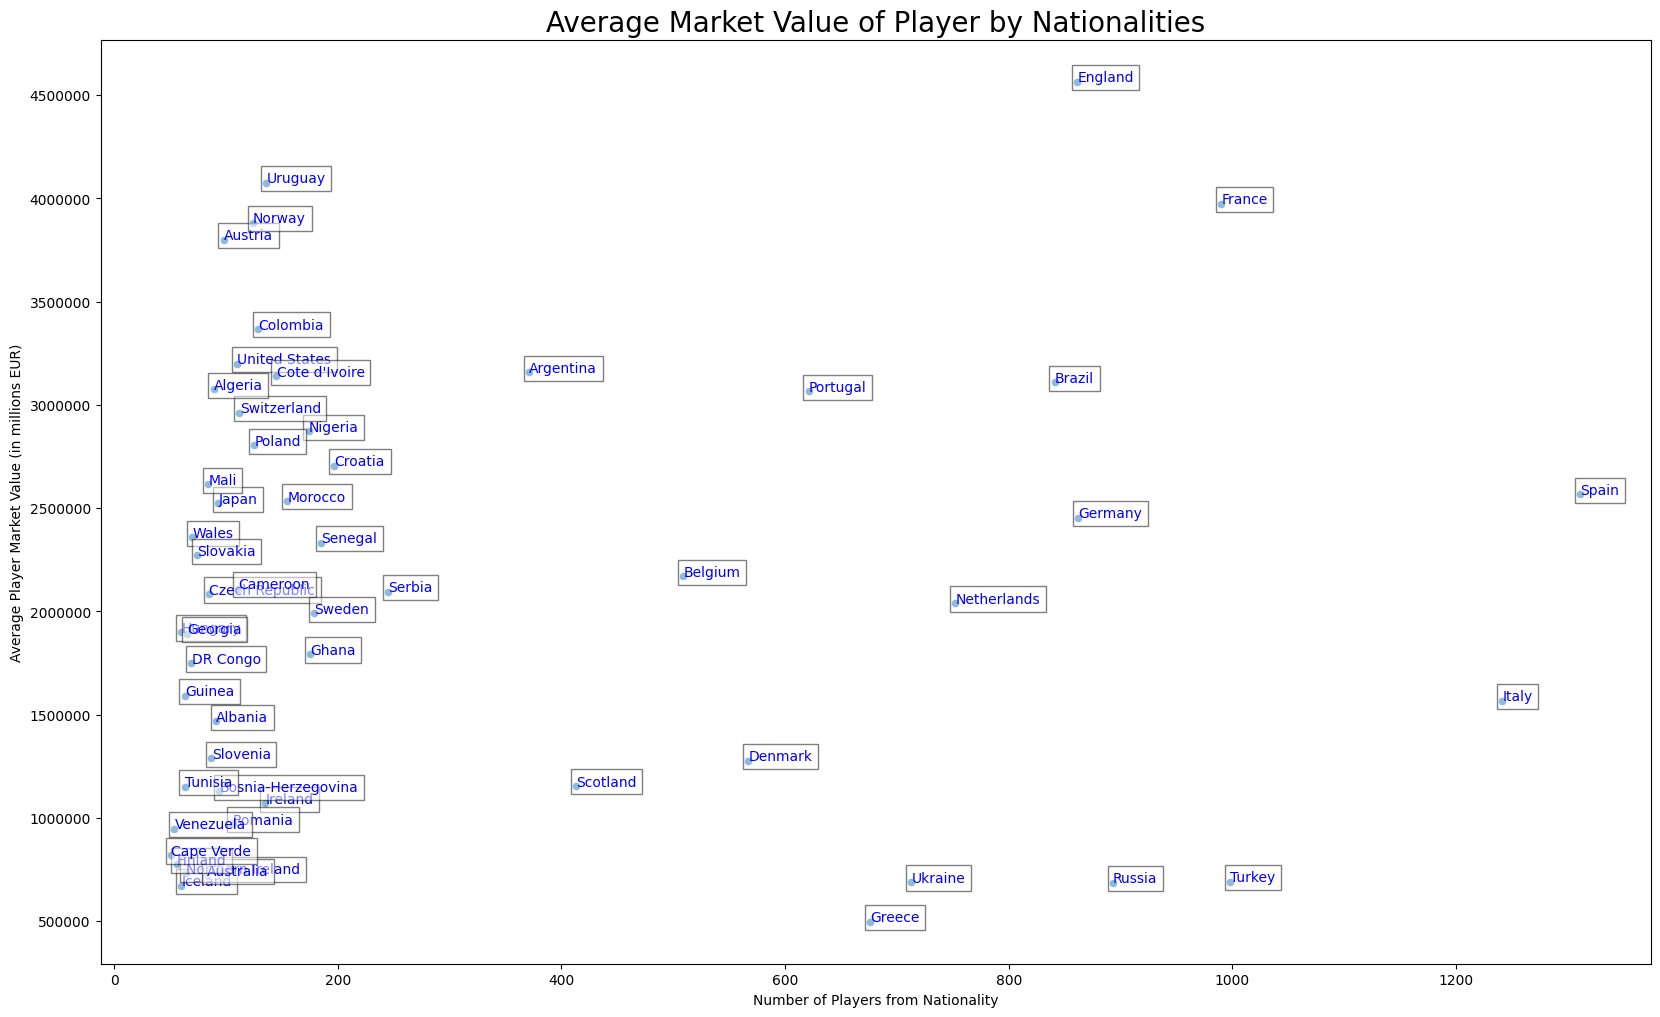

In [22]:
plt.figure(figsize=(20,12))

sns.scatterplot(data=valuesdf, x="Player_Count", y="Average_Market_Value")
plt.title("Average Market Value of Player by Nationalities", size=20)
plt.xlabel("Number of Players from Nationality")
plt.ylabel("Average Player Market Value (in millions EUR)")
plt.ticklabel_format(axis="y",style="plain")


for i in range(valuesdf.shape[0]):
 plt.text(x=valuesdf.Player_Count[i]+0.3,y=valuesdf.Average_Market_Value[i]+0.3,s=valuesdf.Nationalities[i], 
          fontdict=dict(color="b",size=10),
          bbox=dict(facecolor="w",alpha=0.5))

### Player Valuation History

In [23]:
def valuation_history(player):
    playervaldf=df_player_val[df_player_val["player_id"]==player]
    nationality=df_player[df_player["name"]==player].iat[0,4]
    position=df_player[df_player["name"]==player].iat[0,9]
    current_club=df_player[df_player["name"]==player].iat[0,3]
    foot=df_player[df_player["name"]==player].iat[0,10]
    height=df_player[df_player["name"]==player].iat[0,11]
    age=2023-int(df_player[df_player["name"]==player].iat[0,7][:4])
    
    x=playervaldf["season"]
    y=playervaldf["market_value_in_eur"]
    
    fig,ax=plt.subplots(figsize=(12,8))
    g=plt.bar("season", "market_value_in_eur", data=playervaldf)
    
    text=' '.join((" Position: ", str(position),"\n","Age: ", str(age),"\n","Current Club: ", str(current_club),"\n","Nationality: ", str(nationality),"\n","Preferred Foot: ", str(foot), "\n", "Height: ", str(height), "cm"))
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    
    ax.ticklabel_format(axis="y",style="plain")
        
    plt.title(f"{player} Valuation History", size=20)
    plt.xlabel("Seasons", size=15)
    plt.ylabel("Market Valuation (in Euros)", size=15)
    plt.text(1.025, 0.95, text, fontsize=15, bbox=props, ha="left", va="top", transform=ax.transAxes)


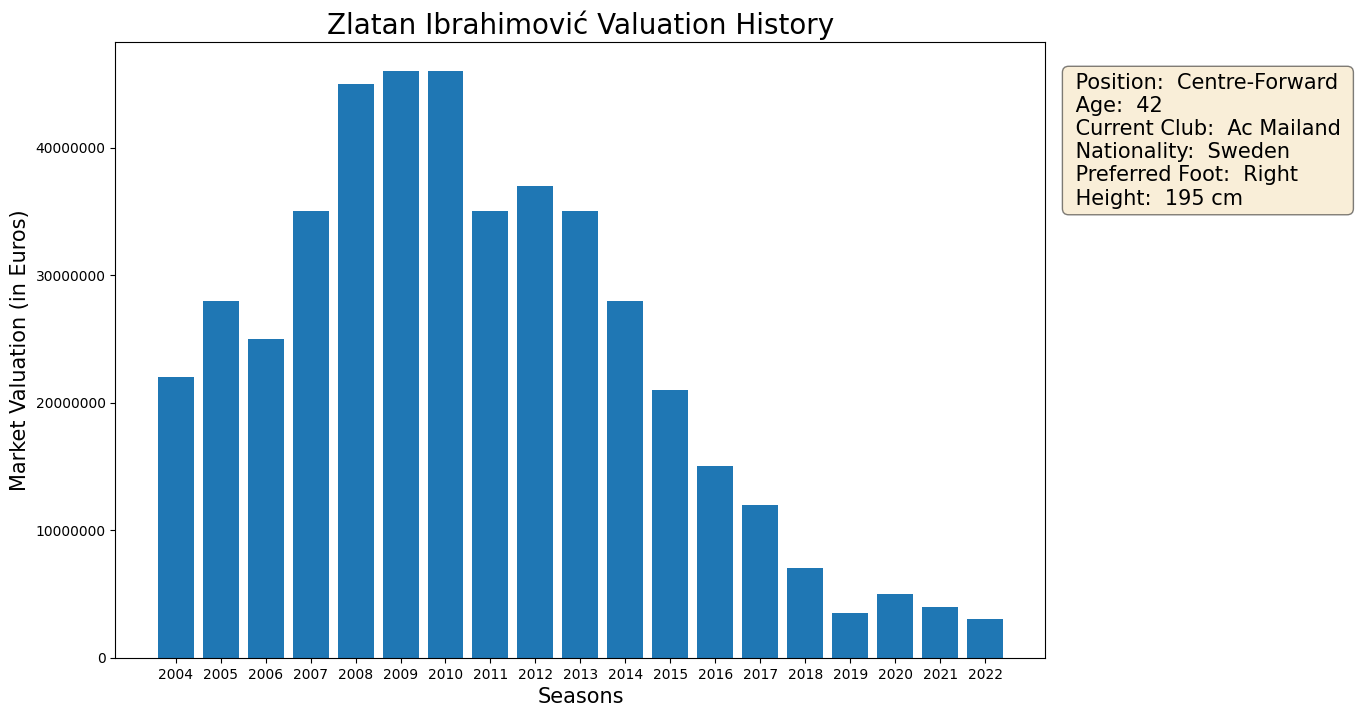

In [24]:
valuation_history("Zlatan Ibrahimović")

### Evolution of League Player Values

In [25]:
seasons=sorted(list(df_player_val["season"].unique()))[:-1]
leagues=list(df_player_val["player_club_domestic_competition_id"].unique())

In [26]:
league_vals_df=pd.DataFrame(index=leagues)

In [27]:
for season in seasons:
    playerseasonval=df_player_val[df_player_val["season"]==season]
    playersbyleague=round(playerseasonval.groupby(["player_club_domestic_competition_id"]).mean())
    leaguevaldict=playersbyleague.to_dict()
    leaguevaldict=leaguevaldict["market_value_in_eur"]
    for league in leagues:
        if league not in leaguevaldict.keys():
            leaguevaldict[league]=0
    league_vals_df[season]=leagues
    league_vals_df=league_vals_df.replace({season:leaguevaldict})

C:\Users\tnaga\AppData\Local\Temp\ipykernel_33572\3554502609.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  playersbyleague=round(playerseasonval.groupby(["player_club_domestic_competition_id"]).mean())
C:\Users\tnaga\AppData\Local\Temp\ipykernel_33572\3554502609.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  playersbyleague=round(playerseasonval.groupby(["player_club_domestic_competition_id"]).mean())
C:\Users\tnaga\AppData\Local\Temp\ipykernel_33572\3554502609.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will def

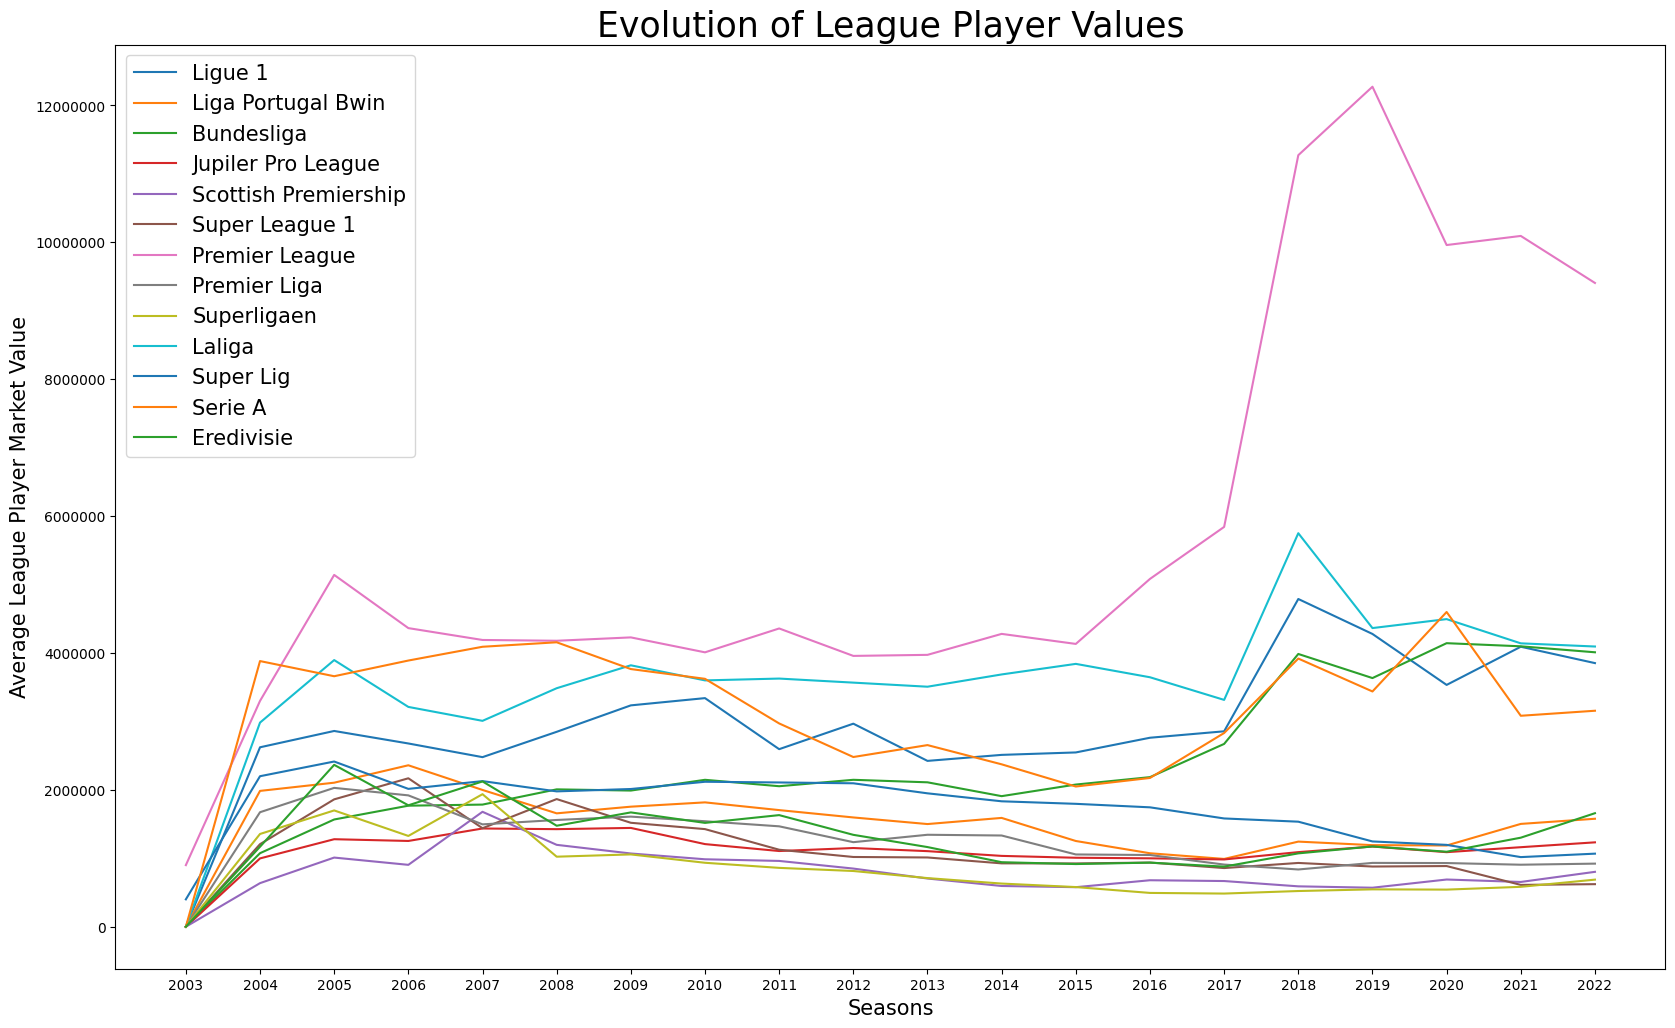

In [28]:
plt.figure(figsize=(20,12))
for league in leagues:
    plt.plot(seasons, league_vals_df.loc[league], label=str(league))

plt.xlabel("Seasons", size=15)
plt.ylabel("Average League Player Market Value", size=15)
plt.ticklabel_format(axis="y",style="plain")
plt.title("Evolution of League Player Values", size=25)
plt.legend(fontsize=15)

In [29]:
df_game

,game_id,competition_id,competition_type,season,round,date,home_club_id,away_club_id,home_club_goals,away_club_goals,...,home_club_position,away_club_position,club_home_name,club_away_name,home_club_manager_name,away_club_manager_name,stadium,attendance,referee,url
0,2229332,Dfl Supercup,other,2012,Final,2012-08-12,27,16,2,1,...,-1,-1,Fc Bayern Munchen,Borussia Dortmund,Jupp Heynckes,Jürgen Klopp,Allianz Arena,69000,Michael Weiner,https://www.transfermarkt.co.uk/spielbericht/i...
1,2244388,Supercopa,other,2012,final 1st leg,2012-08-22,131,418,3,2,...,-1,-1,Fc Barcelona,Real Madrid,Tito Vilanova,José Mourinho,Spotify Camp Nou,91728,Carlos Clos Gómez,https://www.transfermarkt.co.uk/spielbericht/i...
2,2269557,Copa Del Rey,domestic_cup,2012,4th round 2nd leg,2012-11-28,3709,4032,0,0,...,-1,-1,Fc Getafe,NaN,Luis García,Claudio Barragán,Coliseum Alfonso Pérez,2000,Pedro Jesús Pérez Montero,https://www.transfermarkt.co.uk/spielbericht/i...
3,2254432,Copa Del Rey,domestic_cup,2012,First Round Replay,2012-08-30,21322,7077,1,0,...,-1,-1,NaN,NaN,Pedro Buenaventura,Pato,El Palmar,0,Andrés Manuel Ceballos Silva,https://www.transfermarkt.co.uk/spielbericht/i...
4,2221759,Dfb Pokal,domestic_cup,2012,First Round,2012-08-20,109,27,0,4,...,-1,-1,NaN,Fc Bayern Munchen,Oscar Corrochano,Jupp Heynckes,Jahnstadion,12500,Guido Winkmann,https://www.transfermarkt.co.uk/spielbericht/i...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61192,3928809,Kypello Elladas,domestic_cup,2022,Third Round,2022-10-05,21600,4585,0,1,...,-1,-1,NaN,NaN,Georgios Amanatidis,Periklis Amanatidis,Gipedo Neas Efkarpias,0,Dimitrios Takidis,https://www.transfermarkt.co.uk/spielbericht/i...
61193,3942778,Kypello Elladas,domestic_cup,2022,Fifth Round,2022-10-19,3062,2079,1,0,...,-1,-1,NaN,Veria Nps,Leonidas Vokolos,Konstantinos Anyfantakis,Grigoris Lambrakis Stadium,0,Stavros Tsimenteridis,https://www.transfermarkt.co.uk/spielbericht/i...
61194,3962963,Kypello Elladas,domestic_cup,2022,last 16 2nd leg,2023-01-10,1091,9,2,0,...,-1,-1,Paok Thessaloniki,NaN,Razvan Lucescu,Nikolaos Anastopoulos,Toumba Stadium,0,Alexandros Katsikogiannis,https://www.transfermarkt.co.uk/spielbericht/i...
61195,3962951,Kypello Elladas,domestic_cup,2022,last 16 2nd leg,2023-01-11,3060,683,2,2,...,-1,-1,Atromitos Athen,Olympiakos Piraus,Chris Coleman,Michel,Stadio Peristeriou,0,Georgios Tzovaras,https://www.transfermarkt.co.uk/spielbericht/i...


In [30]:
goals_df

,game_id,minute,type,club_id,player_id,description,player_in_id,season,competition
0,2229332,6,Goals,Fc Bayern Munchen,Mario Mandzukic,", Right-footed shot, 1. Tournament Goal",-1,2012,Dfl Supercup
1,2229332,11,Goals,Fc Bayern Munchen,Thomas Müller,", Tap-in, 1. Tournament Goal",-1,2012,Dfl Supercup
2,2229332,75,Goals,Borussia Dortmund,Robert Lewandowski,", Right-footed shot, 1. Tournament Goal",-1,2012,Dfl Supercup
9,2244388,55,Goals,Real Madrid,Cristiano Ronaldo,", Header, 1. Tournament Goal",-1,2012,Supercopa
10,2244388,56,Goals,Fc Barcelona,Pedro,", Right-footed shot, 1. Tournament Goal",-1,2012,Supercopa
...,...,...,...,...,...,...,...,...,...
555896,3962963,13,Goals,Paok Thessaloniki,Brandon Thomas,", Left-footed shot, 3. Tournament Goal",-1,2022,Kypello Elladas
555906,3962951,8,Goals,Atromitos Athen,Georgios Tzovaras,", Left-footed shot, 1. Tournament Goal",-1,2022,Kypello Elladas
555907,3962951,38,Goals,Olympiakos Piraus,Pape Abou Cissé,", Right-footed shot, 1. Tournament Goal",-1,2022,Kypello Elladas
555908,3962951,46,Goals,Olympiakos Piraus,Marcelo,", Left-footed shot, 3. Tournament Goal",-1,2022,Kypello Elladas


### Appearances

In [31]:
df_app.head()

,appearance_id,game_id,player_id,player_club_id,player_current_club_id,date,player_name,competition_id,yellow_cards,red_cards,goals,assists,minutes_played
0,2483937_52453,2483937,52453,28095,28095,2014-08-08,Haris Handzic,RU1,0,0,0,0,90
1,2479929_67064,2479929,67064,28095,4128,2014-08-03,Felicio Brown Forbes,RU1,0,0,0,0,90
2,2483937_67064,2483937,67064,28095,4128,2014-08-08,Felicio Brown Forbes,RU1,0,0,0,0,90
3,2484582_67064,2484582,67064,28095,4128,2014-08-13,Felicio Brown Forbes,RU1,0,0,0,0,55
4,2485965_67064,2485965,67064,28095,4128,2014-08-16,Felicio Brown Forbes,RU1,0,0,0,0,90


In [32]:
df_app.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1049585 entries, 0 to 1049584
Data columns (total 13 columns):
 #   Column                  Non-Null Count    Dtype 
---  ------                  --------------    ----- 
 0   appearance_id           1049585 non-null  object
 1   game_id                 1049585 non-null  int64 
 2   player_id               1049585 non-null  int64 
 3   player_club_id          1049585 non-null  int64 
 4   player_current_club_id  1049585 non-null  int64 
 5   date                    1037678 non-null  object
 6   player_name             1049356 non-null  object
 7   competition_id          1049585 non-null  object
 8   yellow_cards            1049585 non-null  int64 
 9   red_cards               1049585 non-null  int64 
 10  goals                   1049585 non-null  int64 
 11  assists                 1049585 non-null  int64 
 12  minutes_played          1049585 non-null  int64 
dtypes: int64(9), object(4)
memory usage: 104.1+ MB


In [33]:
df_app.describe()

,game_id,player_id,player_club_id,player_current_club_id,yellow_cards,red_cards,goals,assists,minutes_played
count,1.049585e+06,1.049585e+06,1.049585e+06,1.049585e+06,1.049585e+06,1.049585e+06,1.049585e+06,1.049585e+06,1.049585e+06
mean,3.011869e+06,1.746783e+05,2.789166e+03,3.276530e+03,1.498554e-01,3.589038e-03,9.730703e-02,7.384442e-02,7.024827e+01
std,3.790156e+05,1.430548e+05,6.516378e+03,8.051348e+03,3.683817e-01,5.980100e-02,3.341318e-01,2.822423e-01,2.955900e+01
min,-1.000000e+00,1.000000e+01,1.000000e+00,-1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,2.668504e+06,5.887400e+04,2.810000e+02,3.310000e+02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,5.600000e+01
50%,2.995837e+06,1.344250e+05,8.620000e+02,8.730000e+02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,9.000000e+01
75%,3.394722e+06,2.557480e+05,2.441000e+03,2.578000e+03,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,9.000000e+01
max,3.818416e+06,9.877000e+05,7.563500e+04,6.182500e+04,2.000000e+00,1.000000e+00,6.000000e+00,6.000000e+00,1.200000e+02


In [34]:
df_app.isna().sum()

appearance_id                 0
game_id                       0
player_id                     0
player_club_id                0
player_current_club_id        0
date                      11907
player_name                 229
competition_id                0
yellow_cards                  0
red_cards                     0
goals                         0
assists                       0
minutes_played                0
dtype: int64

In [35]:
df_app = df_app.drop(columns=["player_club_id", "player_current_club_id"])

C:\Users\tnaga\AppData\Local\Temp\ipykernel_33572\288813614.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df_app.corr(), annot=True)


<AxesSubplot: >

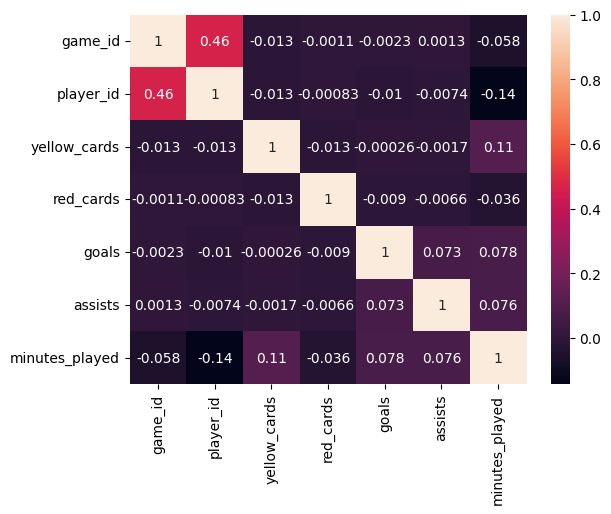

In [36]:
sns.heatmap(df_app.corr(), annot=True)

#### Aggregations in Appearences by Player

In [37]:
df_player_apps = df_app.groupby(by=["player_id", "player_name"]).agg(
    {'yellow_cards':['sum', 'mean'], 
     'red_cards': ['sum','mean'], 
     'goals':['sum', 'mean'], 
     'assists': ['sum','mean'],
     'minutes_played': 'mean',
     'player_id': 'count'
     }
).reset_index()

In [38]:
df_player_apps.columns = [f"{df_player_apps.columns.values[i][0]}_{df_player_apps.columns.values[i][1]}" for i in range(len(df_player_apps.columns))]

In [39]:
df_player_apps.describe()

,player_id_,yellow_cards_sum,yellow_cards_mean,red_cards_sum,red_cards_mean,goals_sum,goals_mean,assists_sum,assists_mean,minutes_played_mean,player_id_count
count,17899.000000,17899.000000,17899.000000,17899.000000,17899.000000,17899.00000,17899.000000,17899.000000,17899.000000,17899.000000,17899.000000
mean,240921.897424,8.785798,0.135617,0.210403,0.003662,5.70490,0.064108,4.330018,0.049129,60.665060,58.626515
std,187574.054528,12.298906,0.138198,0.538579,0.020824,14.29926,0.101272,9.131609,0.072208,23.515119,68.034070
min,10.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,1.000000,1.000000
25%,76962.500000,1.000000,0.028571,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,45.773504,9.000000
50%,203418.000000,4.000000,0.117021,0.000000,0.000000,1.00000,0.024845,1.000000,0.023810,65.320988,32.000000
75%,355481.000000,12.000000,0.200000,0.000000,0.000000,5.00000,0.090909,4.000000,0.077778,79.500000,84.000000
max,987700.000000,106.000000,2.000000,6.000000,1.000000,344.00000,1.500000,172.000000,2.000000,120.000000,406.000000


In [40]:
df_player_apps.corr()

C:\Users\tnaga\AppData\Local\Temp\ipykernel_33572\1065966716.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df_player_apps.corr()


,player_id_,yellow_cards_sum,yellow_cards_mean,red_cards_sum,red_cards_mean,goals_sum,goals_mean,assists_sum,assists_mean,minutes_played_mean,player_id_count
player_id_,1.000000,-0.270018,-0.090790,-0.141995,-0.018087,-0.151636,-0.072351,-0.177729,-0.090232,-0.348477,-0.304321
yellow_cards_sum,-0.270018,1.000000,0.332048,0.443766,0.018388,0.418726,0.162075,0.545125,0.205430,0.343398,0.819398
yellow_cards_mean,-0.090790,0.332048,1.000000,0.112163,0.018223,-0.004343,-0.005037,0.021271,0.008256,0.244235,0.088817
red_cards_sum,-0.141995,0.443766,0.112163,1.000000,0.347449,0.200100,0.073567,0.231495,0.073190,0.207639,0.405756
red_cards_mean,-0.018087,0.018388,0.018223,0.347449,1.000000,-0.011386,-0.022110,-0.014058,-0.016491,0.051791,-0.003024
goals_sum,-0.151636,0.418726,-0.004343,0.200100,-0.011386,1.000000,0.617885,0.762654,0.352600,0.105085,0.623332
goals_mean,-0.072351,0.162075,-0.005037,0.073567,-0.022110,0.617885,1.000000,0.396586,0.315321,0.025851,0.282522
assists_sum,-0.177729,0.545125,0.021271,0.231495,-0.014058,0.762654,0.396586,1.000000,0.537877,0.158832,0.731871
assists_mean,-0.090232,0.205430,0.008256,0.073190,-0.016491,0.352600,0.315321,0.537877,1.000000,0.077880,0.295123
minutes_played_mean,-0.348477,0.343398,0.244235,0.207639,0.051791,0.105085,0.025851,0.158832,0.077880,1.000000,0.351338


C:\Users\tnaga\AppData\Local\Temp\ipykernel_33572\2059050447.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df_player_apps.corr(), annot=True)


<AxesSubplot: >

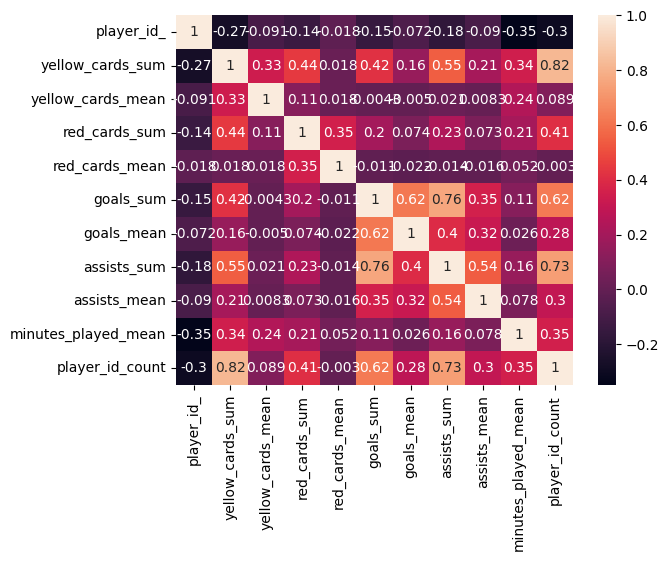

In [41]:
sns.heatmap(df_player_apps.corr(), annot=True)

In [42]:
# plot values of player statistics for players who have played at least 10 games
df_player_apps = df_player_apps[df_player_apps["player_id_count"] > 10]

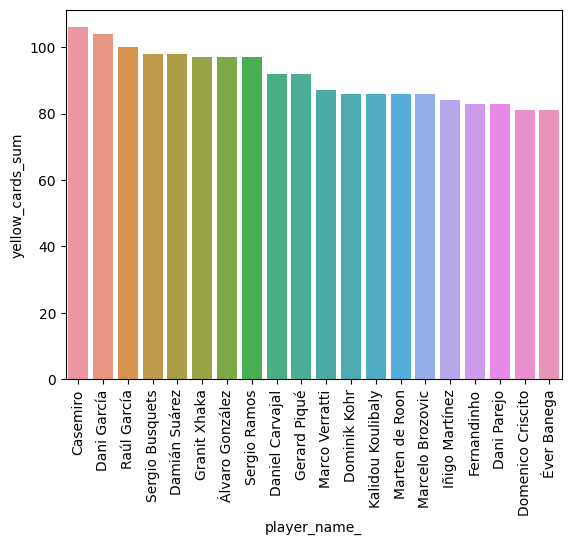

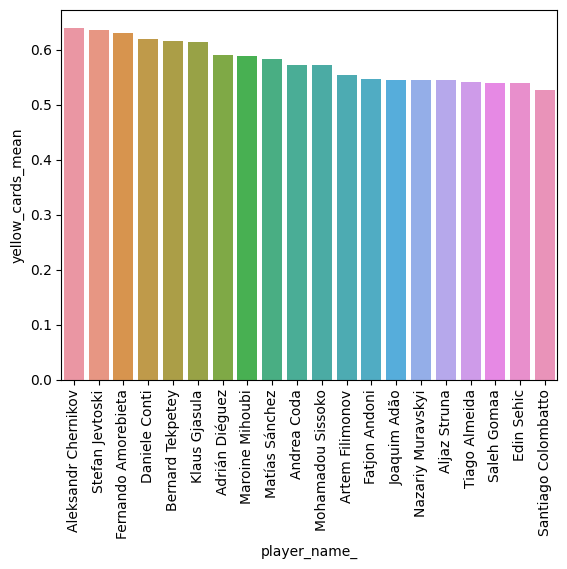

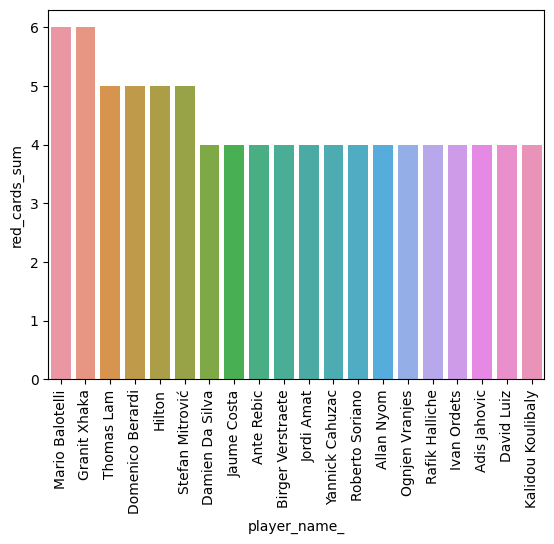

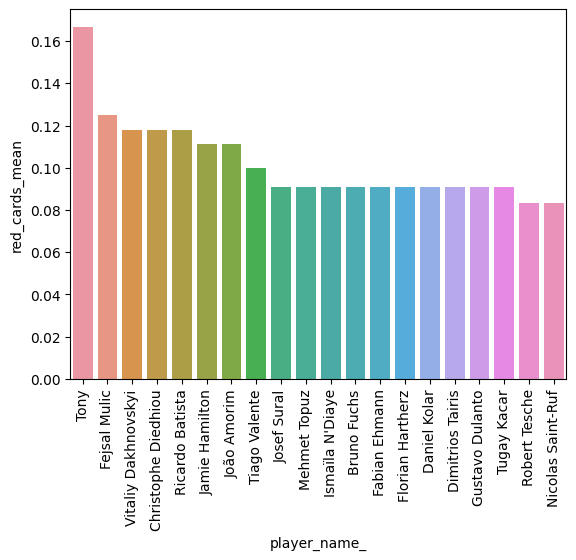

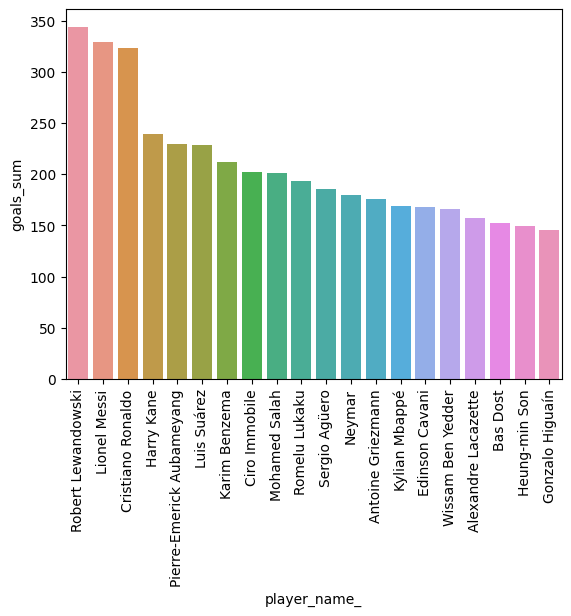

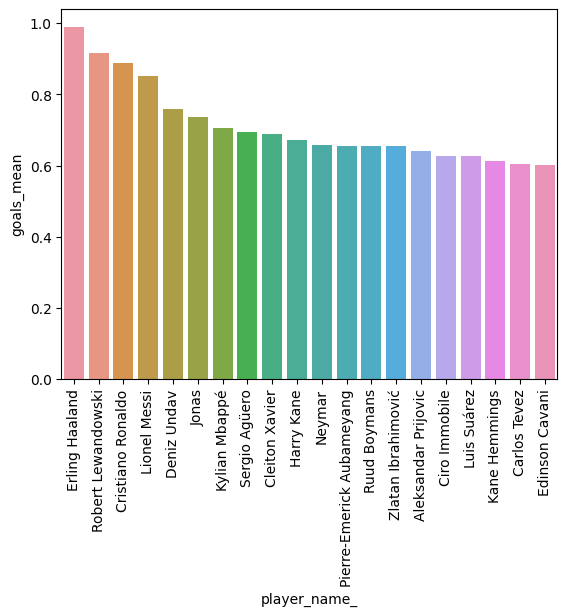

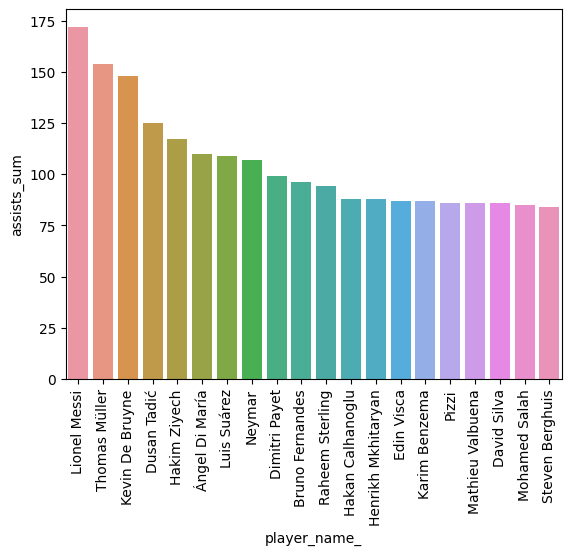

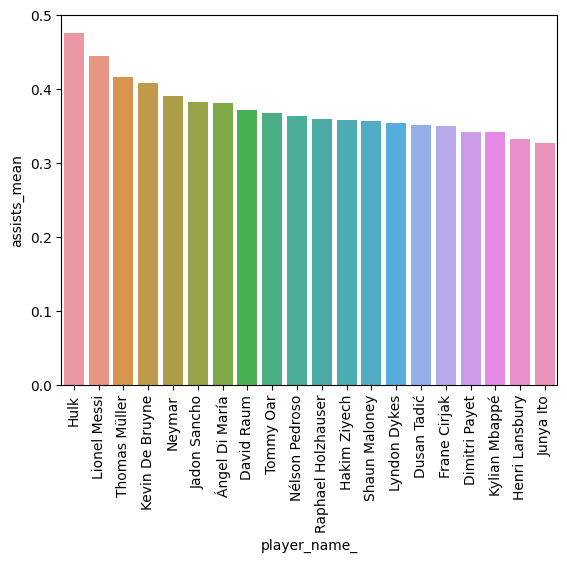

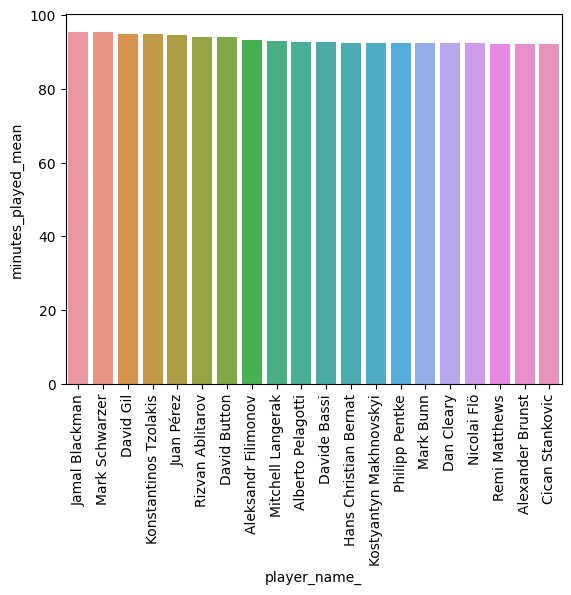

In [43]:
col_list = ['yellow_cards_sum', 'yellow_cards_mean', 'red_cards_sum', 'red_cards_mean', 'goals_sum', 'goals_mean', 'assists_sum', 'assists_mean', 'minutes_played_mean']
for col in col_list:
    df_player_apps_sub = df_player_apps.sort_values(by=col, ascending=False)
    df_player_apps_sub = df_player_apps_sub.iloc[:20,:]
    bar_sub = sns.barplot(df_player_apps_sub, x="player_name_", y=col)
    bar_sub.set_xticklabels(bar_sub.get_xticklabels(), rotation=90)
    plt.show()

### Clubs        

In [44]:
df_club.head()

,club_id,club_code,name,domestic_competition_id,total_market_value,squad_size,average_age,foreigners_number,foreigners_percentage,national_team_players,stadium_name,stadium_seats,net_transfer_record,coach_name,url
0,1032,fc-reading,Fc Reading,GB1,33.66,26,25.9,12,46.2,6,Select Car Leasing Stadium,24161,+£8.37m,Brian McDermott,https://www.transfermarkt.co.uk/fc-reading/sta...
1,2323,orduspor,Orduspor,TR1,NaN,0,NaN,0,NaN,0,19 Eylül Stadyum,11024,+-0,Héctor Cúper,https://www.transfermarkt.co.uk/orduspor/start...
2,1387,acn-siena-1904,Acn Siena 1904,IT1,4.32,30,26.2,6,20.0,2,Artemio Franchi,15373,£-6Th.,Serse Cosmi,https://www.transfermarkt.co.uk/acn-siena-1904...
3,3592,kryvbas-kryvyi-rig,Kryvbas Kryvyi Rig,UKR1,2.95,24,24.5,2,8.3,0,Shakhty Zhovtneva,2500,£-270Th.,Oleg Taran,https://www.transfermarkt.co.uk/kryvbas-kryvyi...
4,1071,wigan-athletic,Wigan Athletic,GB1,12.38,29,26.5,14,48.3,6,DW Stadium,25133,£-140Th.,Roberto Martínez,https://www.transfermarkt.co.uk/wigan-athletic...


In [45]:
df_club.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 401 entries, 0 to 400
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   club_id                  401 non-null    int64  
 1   club_code                401 non-null    object 
 2   name                     401 non-null    object 
 3   domestic_competition_id  401 non-null    object 
 4   total_market_value       354 non-null    float64
 5   squad_size               401 non-null    int64  
 6   average_age              372 non-null    float64
 7   foreigners_number        401 non-null    int64  
 8   foreigners_percentage    357 non-null    float64
 9   national_team_players    401 non-null    int64  
 10  stadium_name             401 non-null    object 
 11  stadium_seats            401 non-null    int64  
 12  net_transfer_record      401 non-null    object 
 13  coach_name               401 non-null    object 
 14  url                      4

In [46]:
df_club.describe()

,club_id,total_market_value,squad_size,average_age,foreigners_number,foreigners_percentage,national_team_players,stadium_seats
count,401.000000,354.000000,401.000000,372.000000,401.000000,357.000000,401.000000,401.000000
mean,4701.932668,91.076130,24.835411,25.605914,10.855362,44.384314,4.917706,25561.037406
std,10244.630906,147.552651,8.200783,1.621027,6.604470,19.177255,5.088292,17913.698519
min,3.000000,1.100000,0.000000,20.000000,0.000000,3.800000,0.000000,1600.000000
25%,410.000000,9.685000,24.000000,24.600000,6.000000,29.200000,1.000000,12080.000000
50%,1108.000000,26.675000,27.000000,25.600000,11.000000,44.800000,3.000000,20560.000000
75%,3368.000000,95.460000,29.000000,26.700000,16.000000,57.700000,8.000000,33280.000000
max,68608.000000,832.320000,40.000000,30.200000,29.000000,100.000000,20.000000,99354.000000


In [47]:
df_club.corr()

C:\Users\tnaga\AppData\Local\Temp\ipykernel_33572\1119422815.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df_club.corr()


,club_id,total_market_value,squad_size,average_age,foreigners_number,foreigners_percentage,national_team_players,stadium_seats
club_id,1.000000,-0.165396,-0.231481,0.036523,-0.288904,-0.226230,-0.265226,-0.130233
total_market_value,-0.165396,1.000000,0.077263,0.190929,0.337336,0.405469,0.736265,0.577401
squad_size,-0.231481,0.077263,1.000000,0.076245,0.623015,0.229142,0.346325,0.110176
average_age,0.036523,0.190929,0.076245,1.000000,0.186006,0.154871,0.242455,0.213829
foreigners_number,-0.288904,0.337336,0.623015,0.186006,1.000000,0.953609,0.660028,0.235681
foreigners_percentage,-0.226230,0.405469,0.229142,0.154871,0.953609,1.000000,0.626135,0.240548
national_team_players,-0.265226,0.736265,0.346325,0.242455,0.660028,0.626135,1.000000,0.596094
stadium_seats,-0.130233,0.577401,0.110176,0.213829,0.235681,0.240548,0.596094,1.000000


C:\Users\tnaga\AppData\Local\Temp\ipykernel_33572\3160475025.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df_club.corr(), annot=True)


<AxesSubplot: >

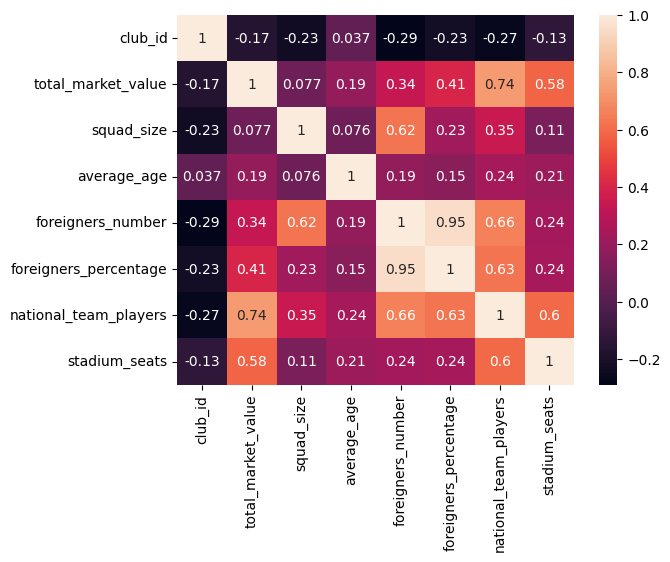

In [48]:
# high correlation between national team players and total market value, squad size 
sns.heatmap(df_club.corr(), annot=True)

#### See the top club market values

In [49]:
# adjust the market value based on squad size
df_club["Adjusted Market Value"] = df_club["total_market_value"] / df_club["squad_size"]
df_club["national_team_players_percentage"] = df_club["national_team_players"] / df_club["squad_size"]

In [50]:
df_club = df_club.sort_values("Adjusted Market Value", ascending=False)
df_club_sub = df_club.iloc[:30,:]

[Text(0, 0, 'Manchester City'),
 Text(1, 0, 'Fc Bayern Munchen'),
 Text(2, 0, 'Gfc Ajaccio'),
 Text(3, 0, 'Real Madrid'),
 Text(4, 0, 'Atletico Madrid'),
 Text(5, 0, 'Fc Liverpool'),
 Text(6, 0, 'Fc Chelsea'),
 Text(7, 0, 'Fc Arsenal'),
 Text(8, 0, 'Tottenham Hotspur'),
 Text(9, 0, 'Fc Paris Saint Germain'),
 Text(10, 0, 'Fc Barcelona'),
 Text(11, 0, 'Inter Mailand'),
 Text(12, 0, 'Manchester United'),
 Text(13, 0, 'Juventus Turin'),
 Text(14, 0, 'Ac Mailand'),
 Text(15, 0, 'Ssc Neapel'),
 Text(16, 0, 'Leicester City'),
 Text(17, 0, 'Rasenballsport Leipzig'),
 Text(18, 0, 'Bayer 04 Leverkusen'),
 Text(19, 0, 'Aston Villa'),
 Text(20, 0, 'Borussia Dortmund'),
 Text(21, 0, 'Elazigspor'),
 Text(22, 0, 'Fc Villarreal'),
 Text(23, 0, 'Fc Everton'),
 Text(24, 0, 'Fc Sevilla'),
 Text(25, 0, 'Atalanta Bergamo'),
 Text(26, 0, 'West Ham United'),
 Text(27, 0, 'As Monaco'),
 Text(28, 0, 'Real Sociedad San Sebastian'),
 Text(29, 0, 'As Rom')]

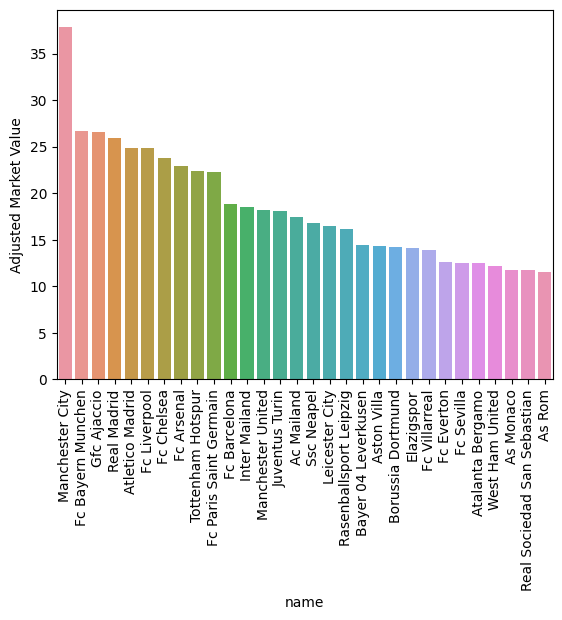

In [51]:
bar_club = sns.barplot(df_club_sub, x="name", y="Adjusted Market Value")
bar_club.set_xticklabels(bar_club.get_xticklabels(), rotation=90)

In [52]:
col_list = ['squad_size', 'average_age', 'foreigners_number', 'foreigners_percentage', 'national_team_players', 'national_team_players_percentage', 'stadium_seats']

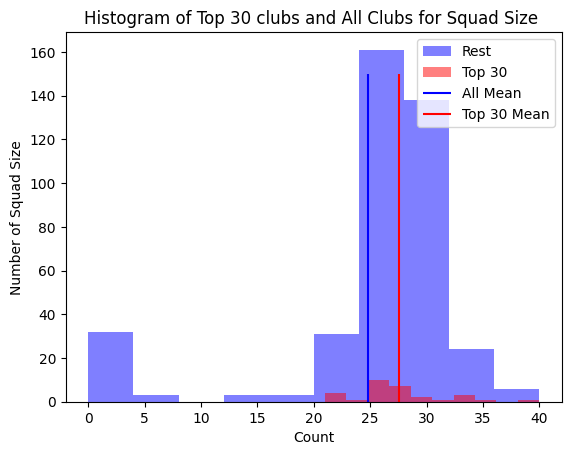

The squad size of all clubs is 24.835411471321695
The squad size of the top 30 clubs by market value is 27.533333333333335


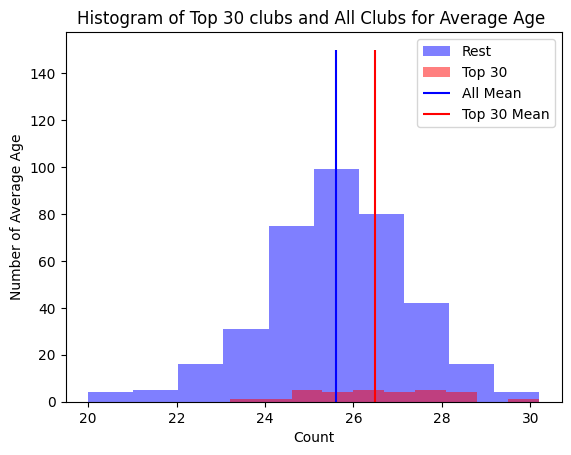

The average age of all clubs is 25.605913978494623
The average age of the top 30 clubs by market value is 26.496666666666666


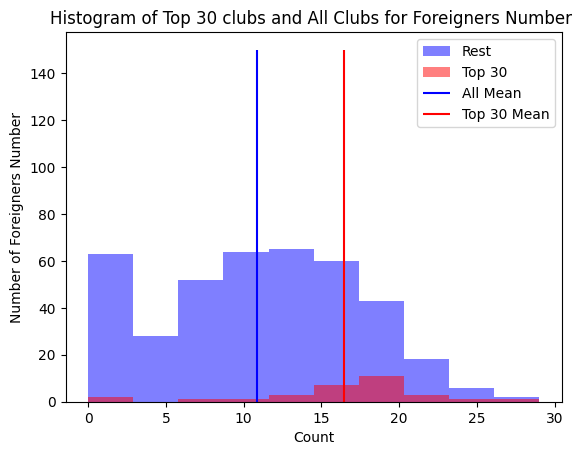

The foreigners number of all clubs is 10.855361596009976
The foreigners number of the top 30 clubs by market value is 16.466666666666665


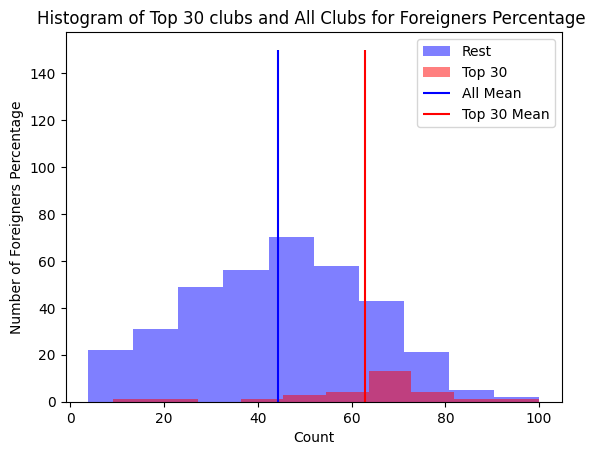

The foreigners percentage of all clubs is 44.384313725490195
The foreigners percentage of the top 30 clubs by market value is 62.817241379310346


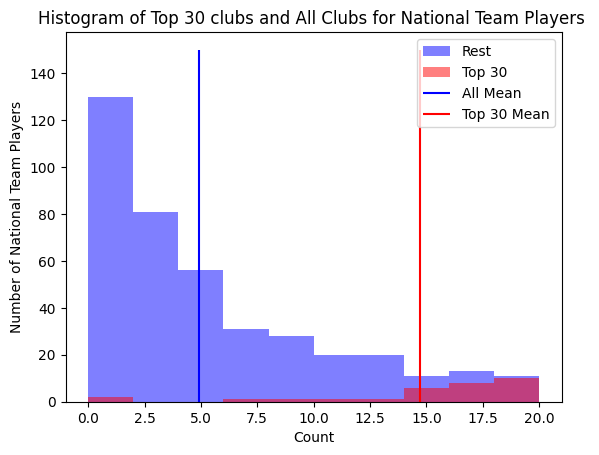

The national team players of all clubs is 4.917705735660848
The national team players of the top 30 clubs by market value is 14.7


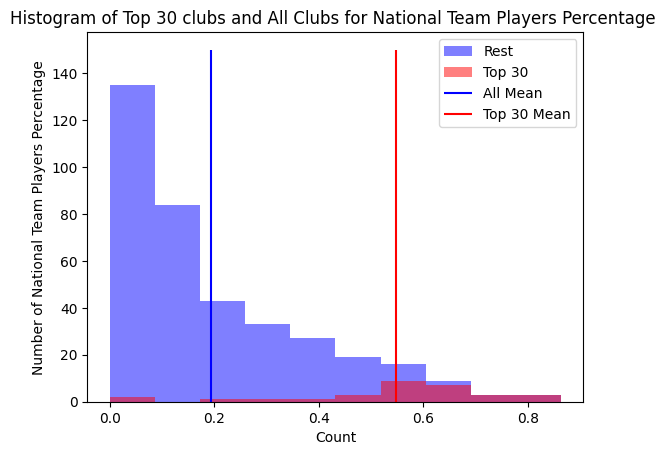

The national team players percentage of all clubs is 0.19417723092903183
The national team players percentage of the top 30 clubs by market value is 0.5478320927805759


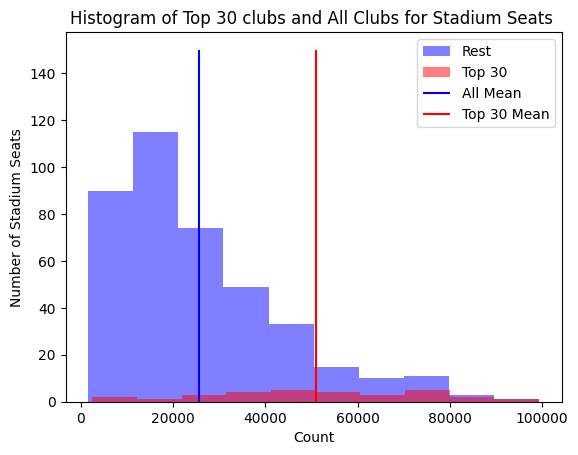

The stadium seats of all clubs is 25561.03740648379
The stadium seats of the top 30 clubs by market value is 51004.53333333333


In [53]:
# the top 30 clubs by market value have a much higher number of national team players and foreign born players

for col in col_list:
    plt.hist(df_club[col], alpha=0.5, color = "blue", label='Rest')
    plt.hist(df_club_sub[col], alpha=0.5, color = "red", label='Top 30')
    plt.vlines(x=df_club[col].mean(), ymin=0, ymax=150, colors="blue", label="All Mean")
    plt.vlines(x=df_club_sub[col].mean(), ymin=0, ymax=150, colors="red", label="Top 30 Mean")
    plt.title(f"Histogram of Top 30 clubs and All Clubs for {' '.join([x.capitalize() for x in col.split('_')])} ")
    plt.xlabel(f"Count")
    plt.ylabel(f"Number of {' '.join([x.capitalize() for x in col.split('_')])}")
    plt.legend(loc='upper right')
    plt.show()
    print(f"The {' '.join(col.split('_'))} of all clubs is {df_club[col].mean()}")
    print(f"The {' '.join(col.split('_'))} of the top 30 clubs by market value is {df_club_sub[col].mean()}")

C:\Users\tnaga\AppData\Local\Temp\ipykernel_33572\967636276.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_club["Adjusted Market Value"])


<AxesSubplot: xlabel='Adjusted Market Value', ylabel='Density'>

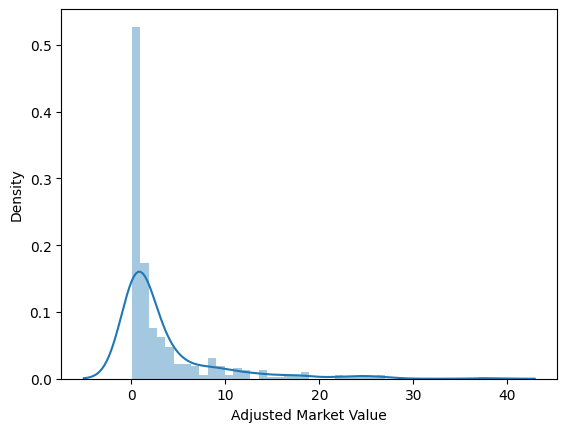

In [54]:
sns.distplot(df_club["Adjusted Market Value"])

In [55]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA

from yellowbrick.cluster import KElbowVisualizer, InterclusterDistance

In [56]:
df_club.columns

Index(['club_id', 'club_code', 'name', 'domestic_competition_id',
       'total_market_value', 'squad_size', 'average_age', 'foreigners_number',
       'foreigners_percentage', 'national_team_players', 'stadium_name',
       'stadium_seats', 'net_transfer_record', 'coach_name', 'url',
       'Adjusted Market Value', 'national_team_players_percentage'],
      dtype='object')

In [57]:
X = df_club[['squad_size', 'average_age', 'foreigners_number','foreigners_percentage', 'national_team_players', 'stadium_seats']]

y = pd.Series(["Top" if club in df_club_sub["name"].to_list() else "No" for club in df_club["name"].to_list()], name="Top_Club")

In [58]:
std_scl = StandardScaler()
X_std = std_scl.fit_transform(X)

imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
X_std = imp_mean.fit_transform(X_std)

pca = PCA(n_components=(len(X_std[0]) - 1))
X_pca = pca.fit_transform(X_std)

<AxesSubplot: >

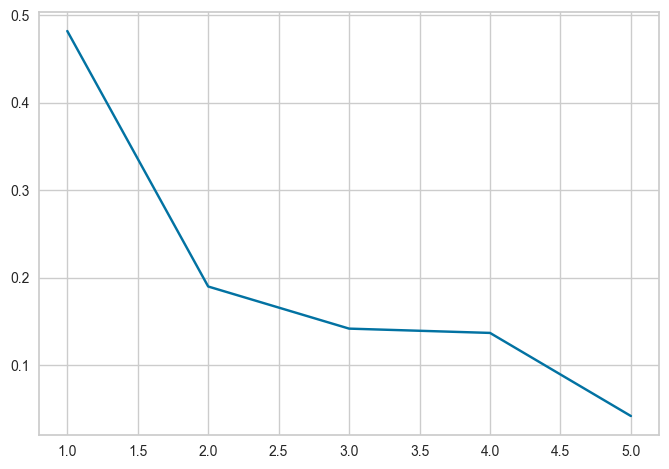

In [59]:
sns.lineplot(x=range(1,len(X_std[0])),y=pca.explained_variance_ratio_)
# elbow is at 3 therefore use the first 3 components

In [60]:
pca = PCA(n_components=3)
X_pca = pca.fit_transform(X_std)

c:\Users\tnaga\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\tnaga\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\tnaga\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\tnaga\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value 

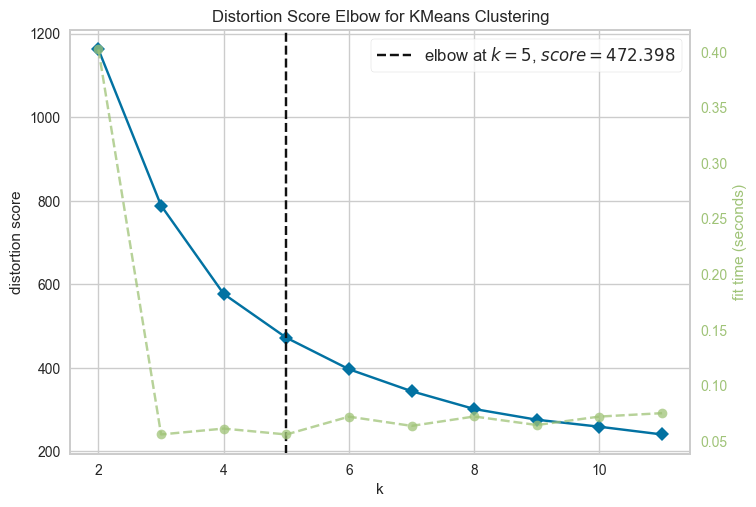

<AxesSubplot: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [61]:
km = KMeans(random_state=42)
visualizer = KElbowVisualizer(km, k=(2,12))
visualizer.fit(X_pca)
visualizer.show()

c:\Users\tnaga\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\tnaga\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


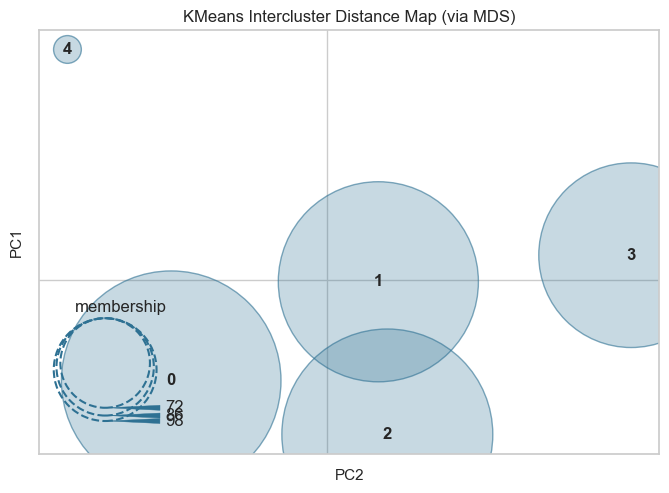

<AxesSubplot: title={'center': 'KMeans Intercluster Distance Map (via MDS)'}, xlabel='PC2', ylabel='PC1'>

In [62]:
interclusterdist = InterclusterDistance(KMeans(5, random_state=42))
interclusterdist.fit(X_pca)        # Fit the data to the visualizer
interclusterdist.show() 

In [63]:
df_pca = pd.DataFrame(X_pca, columns = ["PC1", "PC2", "PC3"])
df_pca = pd.concat([df_pca, y], axis=1)

In [64]:
import plotly.express as px
fig = px.scatter_3d(df_pca, x=f"PC1", y=f"PC2", z=f"PC3", color="Top_Club")
fig.show(renderer="browser")

# most of the difference between the top 30 clubs and the other clubs are explained by principal component 1
# all of the values in the first principal component are positive and most of the top 30 clubs have a positive principal component 1 value

In [65]:
new_cols = ['squad_size', 'average_age', 'foreigners_number','foreigners_percentage', 'national_team_players',
       'stadium_seats']

In [66]:
df_pca_comp = pd.DataFrame(pca.components_, columns = new_cols, index = ["PC1", "PC2", "PC3"])

In [67]:
df_pca_comp.head()

,squad_size,average_age,foreigners_number,foreigners_percentage,national_team_players,stadium_seats
PC1,0.332290,0.180421,0.538739,0.424458,0.524377,0.334149
PC2,-0.566715,0.453170,-0.328172,-0.019717,0.190829,0.573559
PC3,-0.626458,-0.368967,0.133318,0.628595,0.031005,-0.239889


### Club Games      

In [68]:
df_club_game = pd.read_csv("./Data/club_games.csv")

In [69]:
df_clubs_games = pd.merge(df_club, df_club_game, on="club_id", how="left")

In [70]:
df_clubs_games.isna().sum()

club_id                                0
club_code                              0
name                                   0
domestic_competition_id                0
total_market_value                  5101
squad_size                             0
average_age                         3419
foreigners_number                      0
foreigners_percentage               5789
national_team_players                  0
stadium_name                           0
stadium_seats                          0
net_transfer_record                    0
coach_name                             0
url                                    0
Adjusted Market Value               5101
national_team_players_percentage    3419
game_id                                0
own_goals                              0
own_position                           0
own_manager_name                     494
opponent_id                            0
opponent_goals                         0
opponent_position                      0
opponent_manager

In [71]:
df_games_club = df_clubs_games.groupby(by=["club_id", "name", "hosting"]).agg(
    {'own_goals':['sum', 'mean'], 
     'opponent_goals': ['sum','mean'], 
     'is_win': ['sum','mean'],
     'game_id': 'count'
     }
).reset_index()

In [72]:
df_games_club.columns = [f"{df_games_club.columns.values[i][0]}_{df_games_club.columns.values[i][1]}" for i in range(len(df_games_club.columns))]

In [73]:
df_games_club["goal_difference_sum"] = df_games_club["own_goals_sum"] - df_games_club["opponent_goals_sum"]
df_games_club_home = df_games_club[df_games_club["hosting_"] == "Home"]
df_games_club_away = df_games_club[df_games_club["hosting_"] == "Away"]

In [74]:
col_list = ['own_goals_sum', 'own_goals_mean',
       'opponent_goals_sum', 'opponent_goals_mean', 'is_win_sum',
       'is_win_mean', 'game_id_count', 'goal_difference_sum']

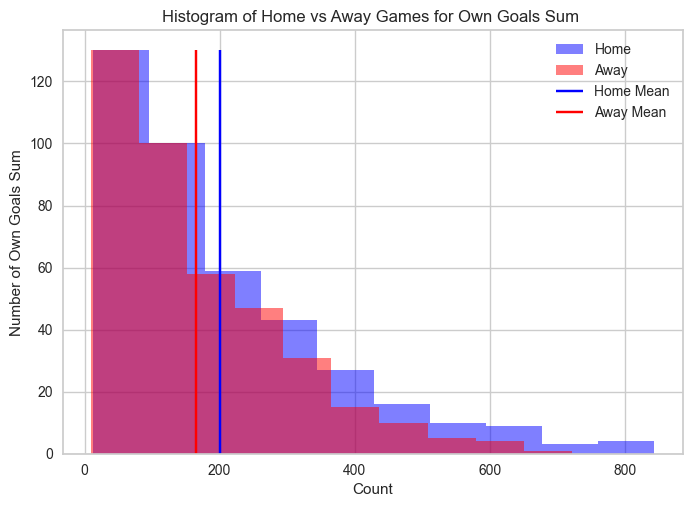

The own goals sum of home games is 199.94513715710724
The own goals sum of away games is 165.54862842892769


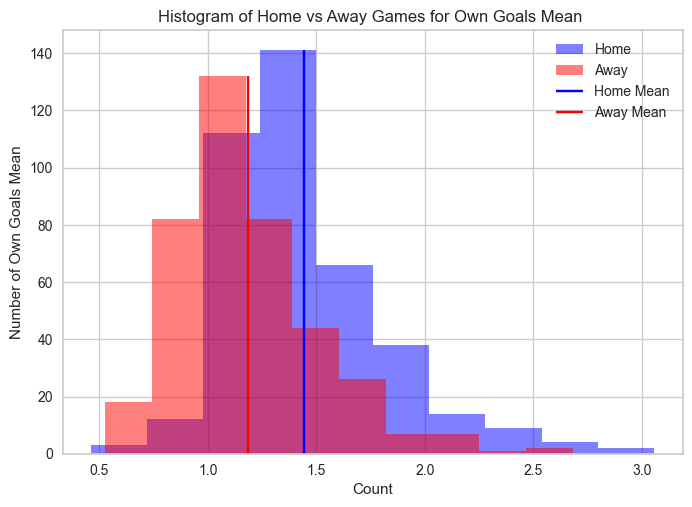

The own goals mean of home games is 1.4453099617092025
The own goals mean of away games is 1.1837135575637836


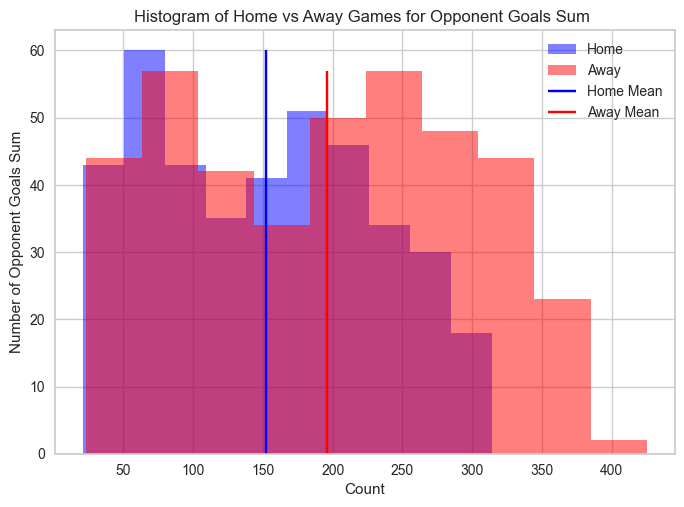

The opponent goals sum of home games is 152.04488778054863
The opponent goals sum of away games is 196.1995012468828


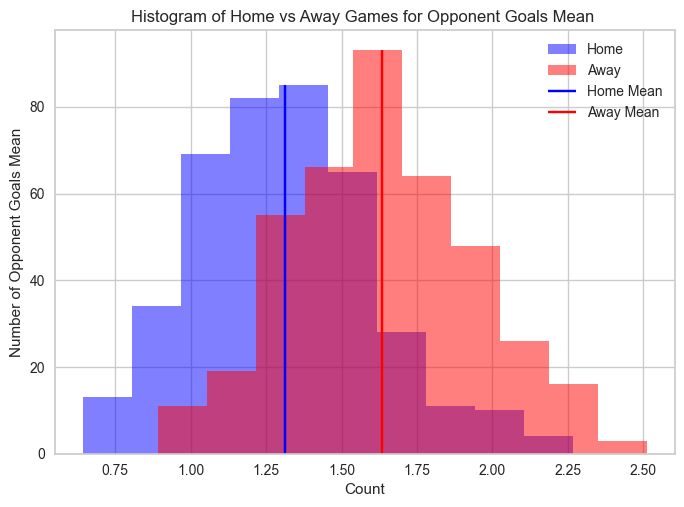

The opponent goals mean of home games is 1.3120016897929359
The opponent goals mean of away games is 1.635526641172725


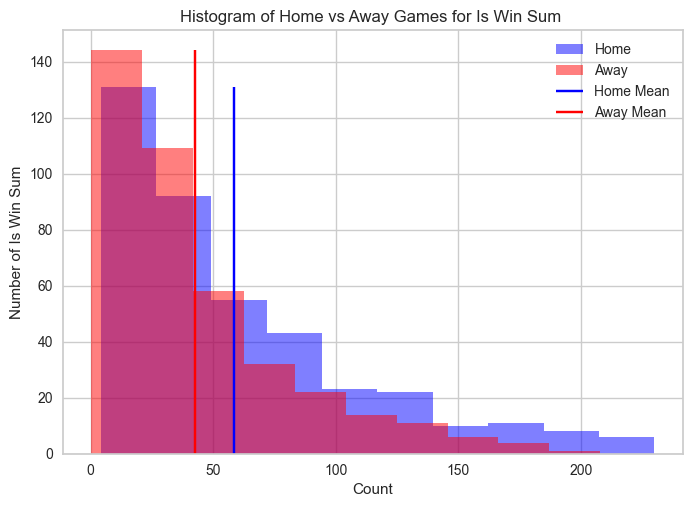

The is win sum of home games is 58.48877805486284
The is win sum of away games is 42.4788029925187


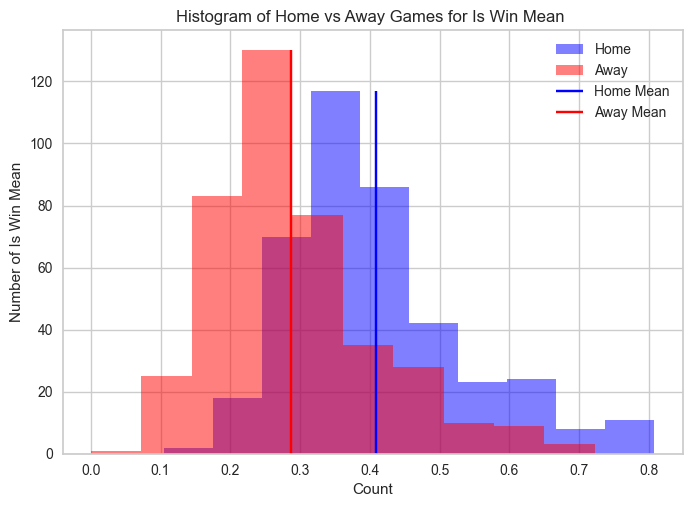

The is win mean of home games is 0.409339564627269
The is win mean of away games is 0.2871236676209519


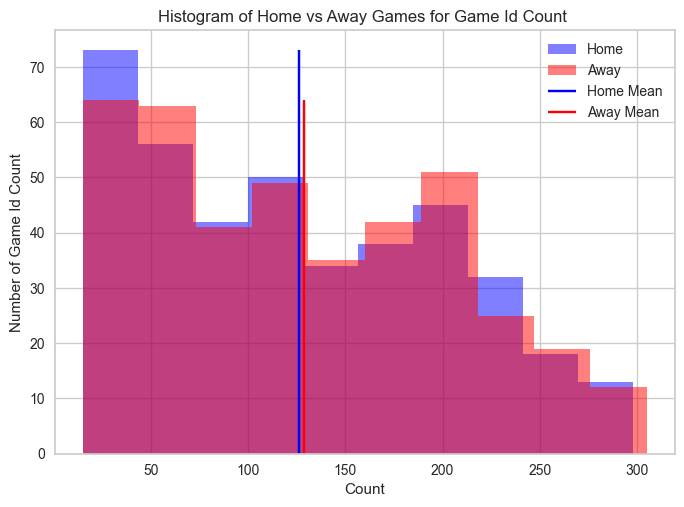

The game id count of home games is 126.28927680798004
The game id count of away games is 128.93266832917706


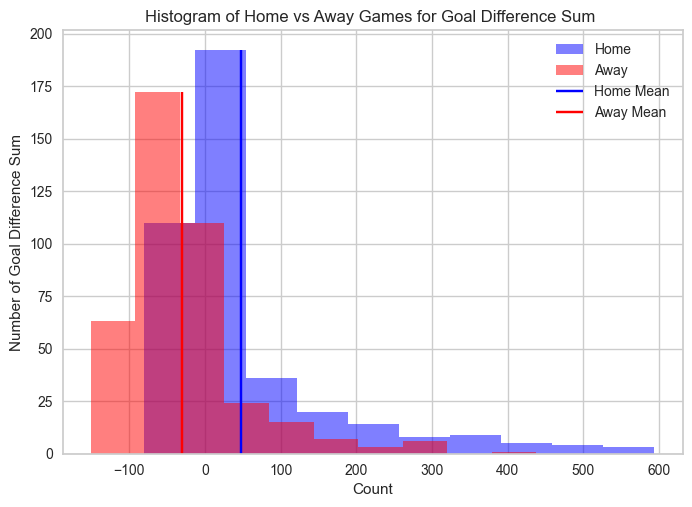

The goal difference sum of home games is 47.900249376558605
The goal difference sum of away games is -30.65087281795511


In [75]:
# clubs are more likely to win home games vs away games
# the home club team scores about 0.3 more goals per game compared to away club teams

for col in col_list:
    y1, x1, _1 = plt.hist(df_games_club_home[col], alpha=0.5, color = "blue", label='Home')
    y2, x2, _2 = plt.hist(df_games_club_away[col], alpha=0.5, color = "red", label='Away')
    plt.vlines(x=df_games_club_home[col].mean(), ymin=0, ymax=y1.max(), colors="blue", label="Home Mean")
    plt.vlines(x=df_games_club_away[col].mean(), ymin=0, ymax=y2.max(), colors="red", label="Away Mean")
    plt.title(f"Histogram of Home vs Away Games for {' '.join([x.capitalize() for x in col.split('_')])} ")
    plt.xlabel("Count")
    plt.ylabel(f"Number of {' '.join([x.capitalize() for x in col.split('_')])}")
    plt.legend(loc='upper right')
    plt.show()
    print(f"The {' '.join(col.split('_'))} of home games is {df_games_club_home[col].mean()}")
    print(f"The {' '.join(col.split('_'))} of away games is {df_games_club_away[col].mean()}")

In [76]:
df_player_games = pd.merge(df_app, df_clubs_games, on="game_id", how="inner")

In [77]:
df_game_players = df_player_games.groupby(by=["player_id", "player_name", "hosting"]).agg(
    {'own_goals':['sum', 'mean'], 
     'opponent_goals': ['sum','mean'], 
     'is_win': ['sum','mean'],
     'game_id': 'count'
     }
).reset_index()

In [78]:
df_game_players.columns = [f"{df_game_players.columns.values[i][0]}_{df_game_players.columns.values[i][1]}" for i in range(len(df_game_players.columns))]

In [79]:
df_game_players["goal_difference_sum"] = df_game_players["own_goals_sum"] - df_games_club["opponent_goals_sum"]
df_game_players_home = df_game_players[df_game_players["hosting_"] == "Home"]
df_game_players_away = df_game_players[df_game_players["hosting_"] == "Away"]

In [80]:
col_list = ['own_goals_sum', 'own_goals_mean',
       'opponent_goals_sum', 'opponent_goals_mean', 'is_win_sum',
       'is_win_mean', 'game_id_count', 'goal_difference_sum']

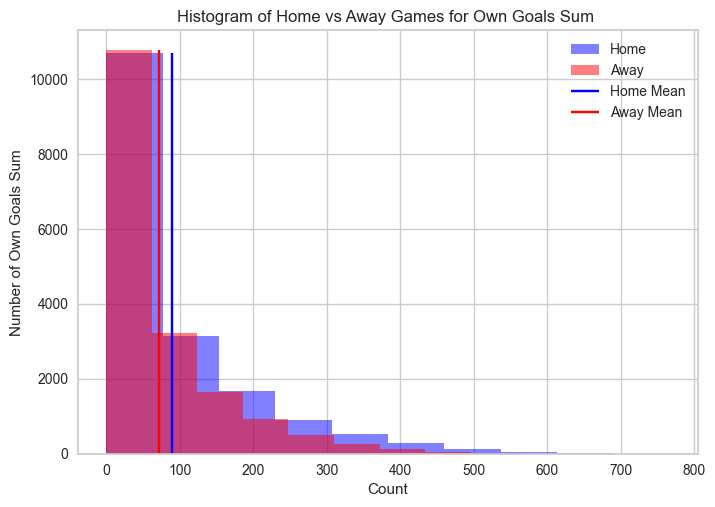

The own goals sum of home games is 90.19985060047118
The own goals sum of away games is 72.07202785229154


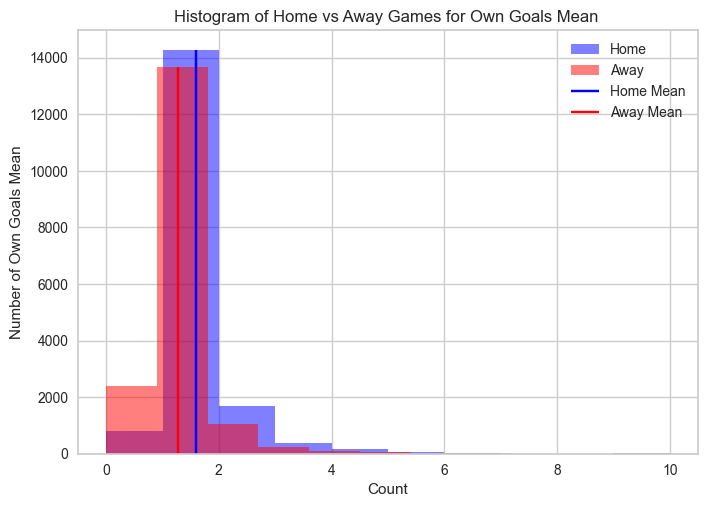

The own goals mean of home games is 1.5976981754296704
The own goals mean of away games is 1.2681487601712305


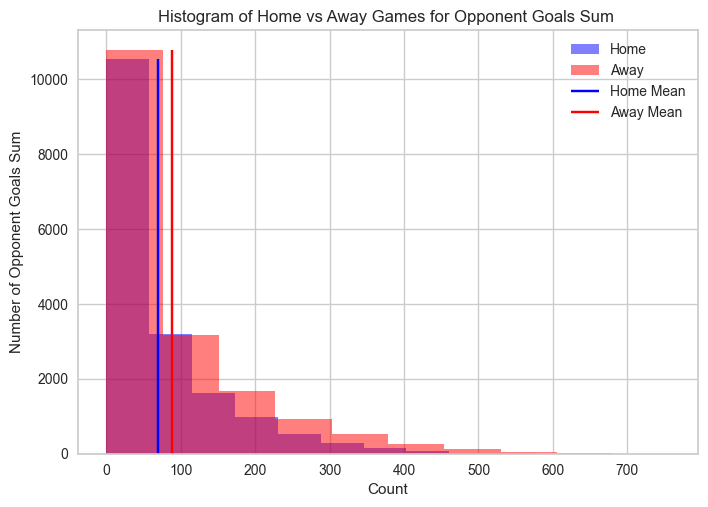

The opponent goals sum of home games is 69.84560133310349
The opponent goals sum of away games is 88.77826608070316


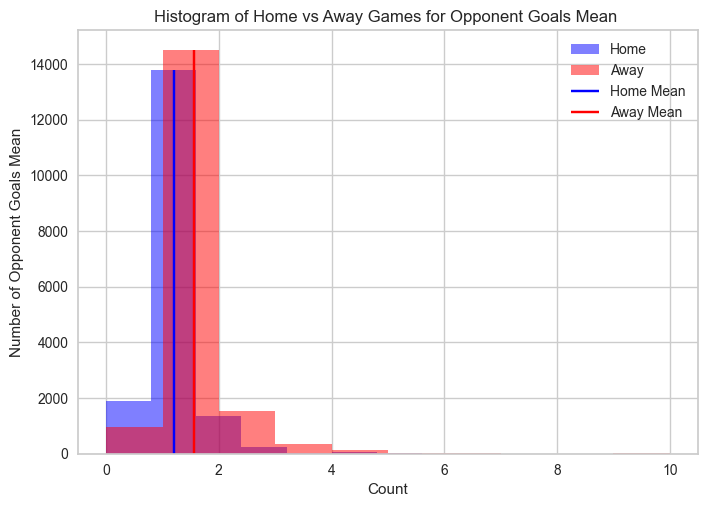

The opponent goals mean of home games is 1.2006292895220665
The opponent goals mean of away games is 1.5501150314731464


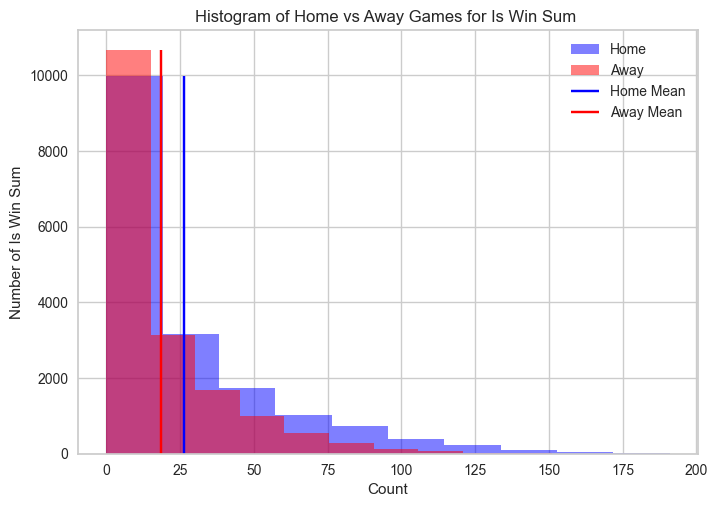

The is win sum of home games is 26.317531460093086
The is win sum of away games is 18.45722276125792


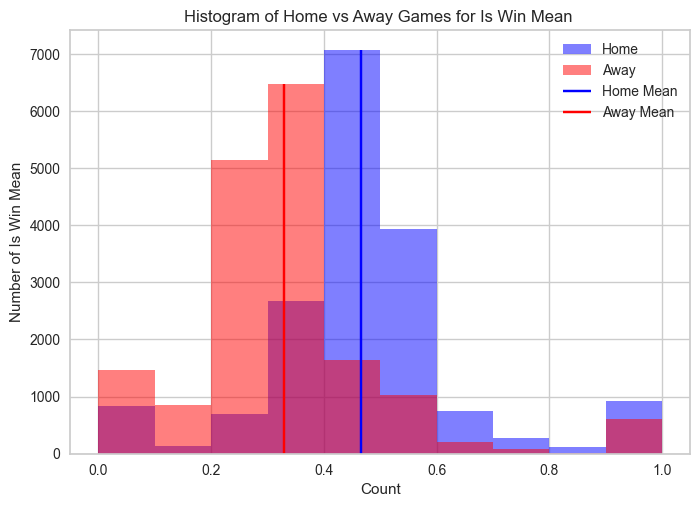

The is win mean of home games is 0.4657764591831159
The is win mean of away games is 0.32849110669702214


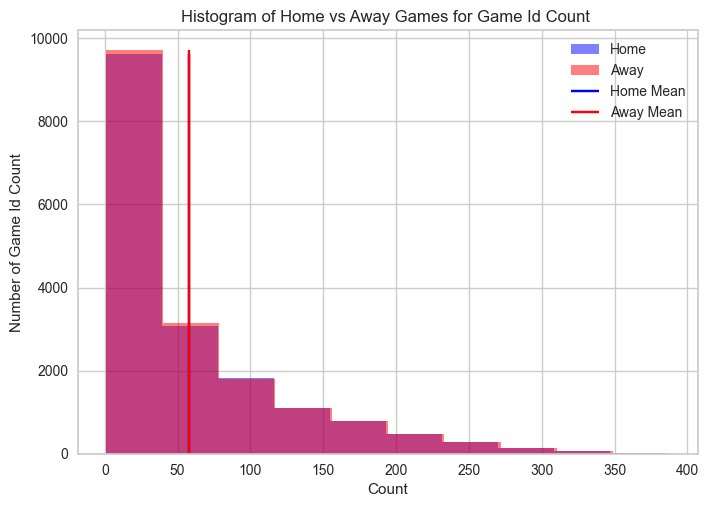

The game id count of home games is 57.88358329023732
The game id count of away games is 57.99400719137036


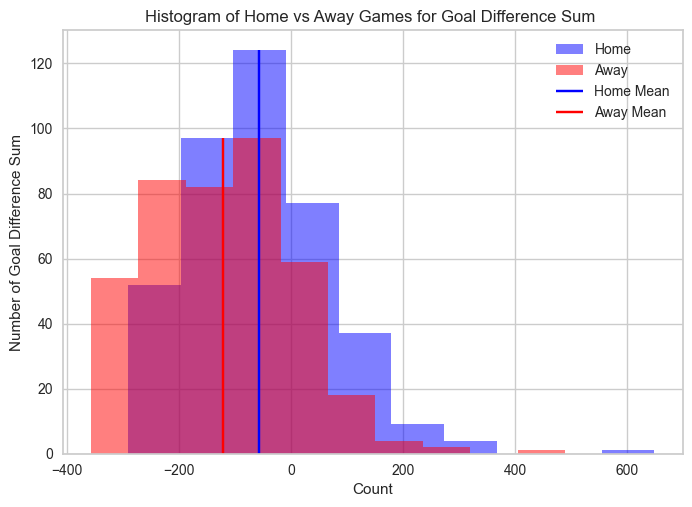

The goal difference sum of home games is -56.54364089775561
The goal difference sum of away games is -122.12718204488777


In [81]:
# clubs are more likely to win home games vs away games
# the home club team scores about 0.3 more goals per game compared to away club teams

for col in col_list:
    y1, x1, _1 = plt.hist(df_game_players_home[col], alpha=0.5, color = "blue", label='Home')
    y2, x2, _2 = plt.hist(df_game_players_away[col], alpha=0.5, color = "red", label='Away')
    plt.vlines(x=df_game_players_home[col].mean(), ymin=0, ymax=y1.max(), colors="blue", label="Home Mean")
    plt.vlines(x=df_game_players_away[col].mean(), ymin=0, ymax=y2.max(), colors="red", label="Away Mean")
    plt.title(f"Histogram of Home vs Away Games for {' '.join([x.capitalize() for x in col.split('_')])} ")
    plt.xlabel("Count")
    plt.ylabel(f"Number of {' '.join([x.capitalize() for x in col.split('_')])}")
    plt.legend(loc='upper right')
    plt.show()
    print(f"The {' '.join(col.split('_'))} of home games is {df_game_players_home[col].mean()}")
    print(f"The {' '.join(col.split('_'))} of away games is {df_game_players_away[col].mean()}")

In [82]:
df_player = df_player.sort_values(by="highest_market_value_in_eur", ascending=False)
top_1000_players = df_player["player_id"].iloc[:1000].to_list()

In [83]:
df_game_players["goal_difference_sum"] = df_game_players["own_goals_sum"] - df_games_club["opponent_goals_sum"]
df_game_players_top1000 = df_game_players[df_game_players["player_id_"].isin(top_1000_players)].copy()
df_game_players_top1000_home = df_game_players_top1000[df_game_players_top1000["hosting_"] == "Home"].copy()
df_game_players_top1000_away = df_game_players_top1000[df_game_players_top1000["hosting_"] == "Away"].copy()
df_game_players_rest = df_game_players[~(df_game_players["player_id_"].isin(top_1000_players))].copy()
df_game_players_rest_home = df_game_players_rest[df_game_players_rest["hosting_"] == "Home"].copy()
df_game_players_rest_away = df_game_players_rest[df_game_players_rest["hosting_"] == "Away"].copy()

In [84]:
col_list = ['own_goals_sum', 'own_goals_mean',
       'opponent_goals_sum', 'opponent_goals_mean', 'is_win_sum',
       'is_win_mean', 'game_id_count', 'goal_difference_sum']

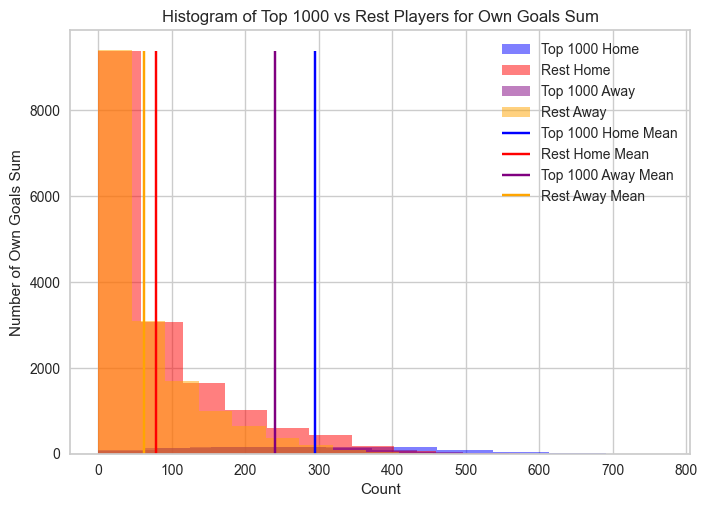

The own goals sum of top 1000 players games Home is 295.2917093142272
The own goals sum of top 1000 players games Away is 239.89559877175026
The own goals sum of rest of players games Home is 78.00121758188239
The own goals sum of rest of players games Away is 62.1612669245648


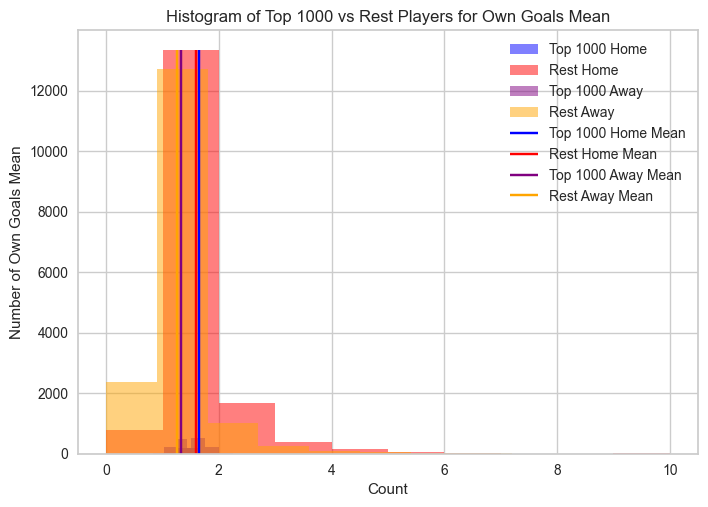

The own goals mean of top 1000 players games Home is 1.6427441359419055
The own goals mean of top 1000 players games Away is 1.3355728437029981
The own goals mean of rest of players games Home is 1.5950188923771653
The own goals mean of rest of players games Away is 1.2641670550448683


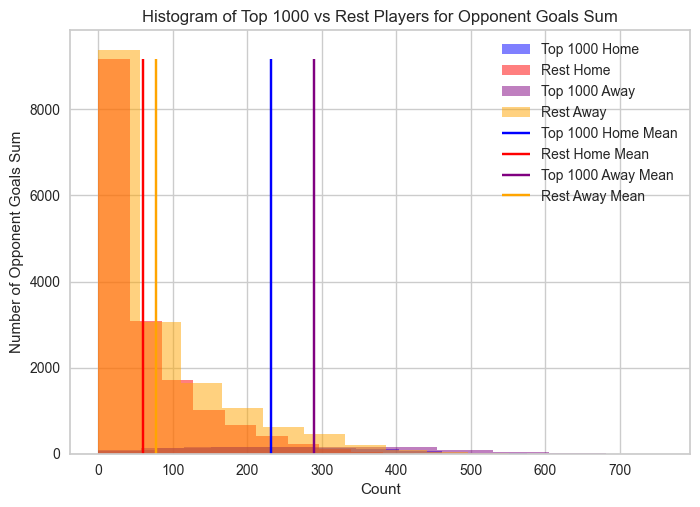

The opponent goals sum of top 1000 players games Home is 231.3940634595701
The opponent goals sum of top 1000 players games Away is 289.5506653019447
The opponent goals sum of rest of players games Home is 60.23688055521734
The opponent goals sum of rest of players games Away is 76.92172388781431


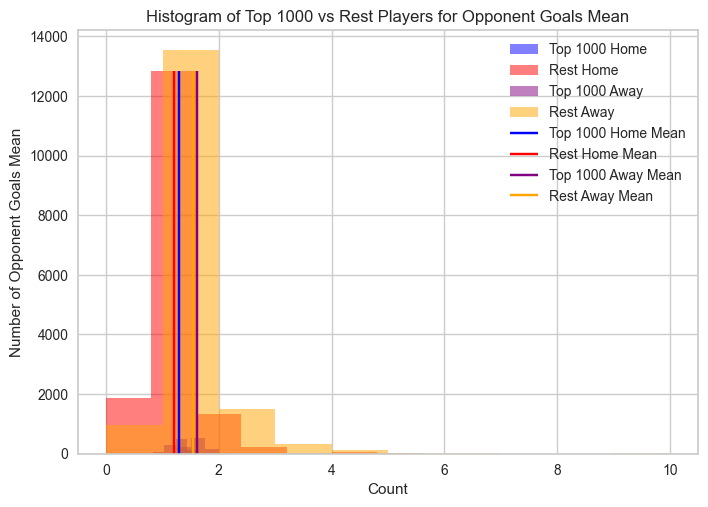

The opponent goals mean of top 1000 players games Home is 1.2971858350553285
The opponent goals mean of top 1000 players games Away is 1.6056576358337455
The opponent goals mean of rest of players games Home is 1.1948862148242705
The opponent goals mean of rest of players games Away is 1.5468349828476444


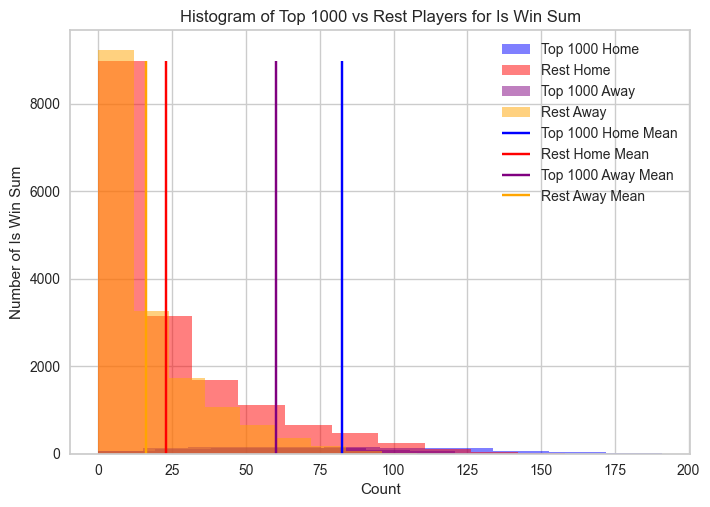

The is win sum of top 1000 players games Home is 82.36438075742068
The is win sum of top 1000 players games Away is 60.13715455475947
The is win sum of rest of players games Home is 22.983927919152563
The is win sum of rest of players games Away is 15.995829303675048


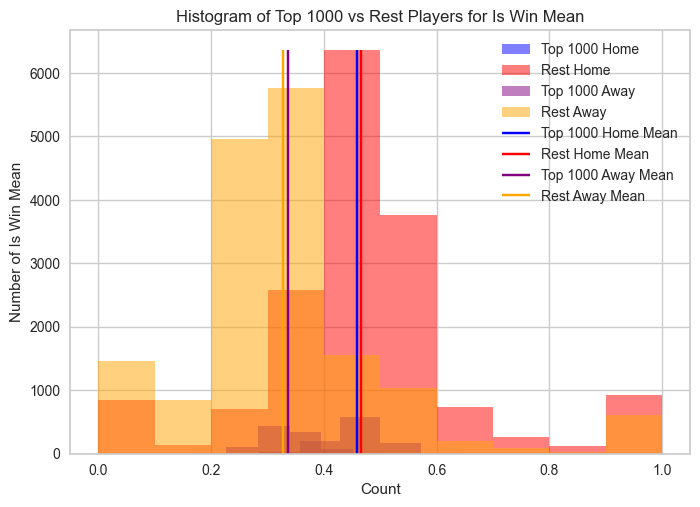

The is win mean of top 1000 players games Home is 0.45896068885628033
The is win mean of top 1000 players games Away is 0.33549501839528983
The is win mean of rest of players games Home is 0.46618185353410324
The is win mean of rest of players games Away is 0.3280774931979163


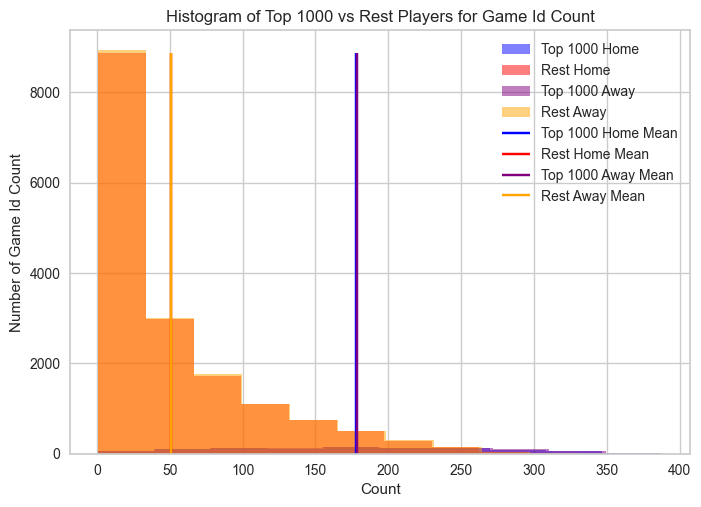

The game id count of top 1000 players games Home is 177.83623336745137
The game id count of top 1000 players games Away is 178.67860798362332
The game id count of rest of players games Home is 50.74893461585292
The game id count of rest of players games Away is 50.86702127659574


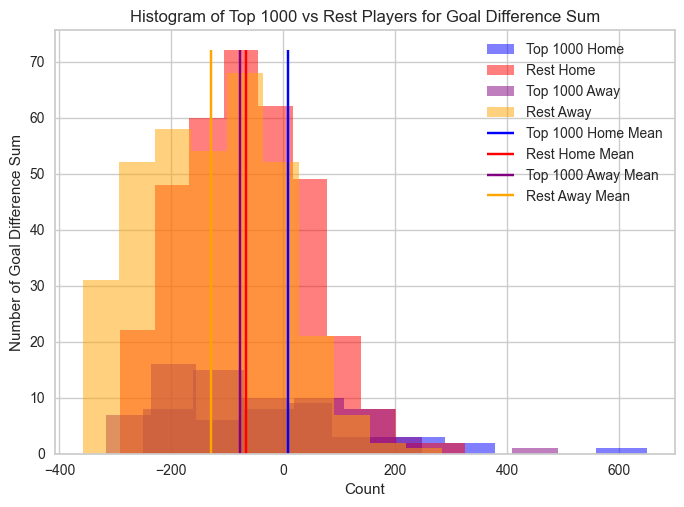

The goal difference sum of top 1000 players games Home is 8.909090909090908
The goal difference sum of top 1000 players games Away is -77.03636363636363
The goal difference sum of rest of players games Home is -66.94797687861272
The goal difference sum of rest of players games Away is -129.29479768786126


In [85]:
# clubs are more likely to win home games vs away games
# the home club team scores about 0.3 more goals per game compared to away club teams

for col in col_list:
    y1, x1, _1 = plt.hist(df_game_players_top1000_home[col], alpha=0.5, color = "blue", label='Top 1000 Home')
    y2, x2, _2 = plt.hist(df_game_players_rest_home[col], alpha=0.5, color = "red", label='Rest Home')
    y3, x3, _3 = plt.hist(df_game_players_top1000_away[col], alpha=0.5, color = "purple", label='Top 1000 Away')
    y4, x4, _4 = plt.hist(df_game_players_rest_away[col], alpha=0.5, color = "orange", label='Rest Away')
    plt.vlines(x=df_game_players_top1000_home[col].mean(), ymin=0, ymax=y2.max(), colors="blue", label="Top 1000 Home Mean")
    plt.vlines(x=df_game_players_rest_home[col].mean(), ymin=0, ymax=y2.max(), colors="red", label="Rest Home Mean")
    plt.vlines(x=df_game_players_top1000_away[col].mean(), ymin=0, ymax=y2.max(), colors="purple", label="Top 1000 Away Mean")
    plt.vlines(x=df_game_players_rest_away[col].mean(), ymin=0, ymax=y2.max(), colors="orange", label="Rest Away Mean")
    plt.title(f"Histogram of Top 1000 vs Rest Players for {' '.join([x.capitalize() for x in col.split('_')])}")
    plt.xlabel("Count")
    plt.ylabel(f"Number of {' '.join([x.capitalize() for x in col.split('_')])}")
    plt.legend(loc='upper right')
    plt.show()
    print(f"The {' '.join(col.split('_'))} of top 1000 players games Home is {df_game_players_top1000_home[col].mean()}")
    print(f"The {' '.join(col.split('_'))} of top 1000 players games Away is {df_game_players_top1000_away[col].mean()}")
    print(f"The {' '.join(col.split('_'))} of rest of players games Home is {df_game_players_rest_home[col].mean()}")
    print(f"The {' '.join(col.split('_'))} of rest of players games Away is {df_game_players_rest_away[col].mean()}")

### Competitions

In [86]:
df_comp = pd.read_csv("./Data/competitions.csv")

In [87]:
df_comp.head()

,competition_id,competition_code,name,type,sub_type,country_id,country_name,country_latitude,country_longitude,domestic_league_code,confederation,url
0,L1,bundesliga,Bundesliga,domestic_league,first_tier,40,Germany,51.163818,10.447831,L1,europa,https://www.transfermarkt.co.uk/bundesliga/sta...
1,DFB,dfb-pokal,Dfb Pokal,domestic_cup,domestic_cup,40,Germany,51.163818,10.447831,L1,europa,https://www.transfermarkt.co.uk/dfb-pokal/star...
2,DFL,dfl-supercup,Dfl Supercup,other,domestic_super_cup,40,Germany,51.163818,10.447831,L1,europa,https://www.transfermarkt.co.uk/dfl-supercup/s...
3,NL1,eredivisie,Eredivisie,domestic_league,first_tier,122,Netherlands,52.243498,5.634323,NL1,europa,https://www.transfermarkt.co.uk/eredivisie/sta...
4,NLP,toto-knvb-beker,Toto Knvb Beker,domestic_cup,domestic_cup,122,Netherlands,52.243498,5.634323,NL1,europa,https://www.transfermarkt.co.uk/toto-knvb-beke...


In [88]:
df_comp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43 entries, 0 to 42
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   competition_id        43 non-null     object 
 1   competition_code      43 non-null     object 
 2   name                  43 non-null     object 
 3   type                  43 non-null     object 
 4   sub_type              43 non-null     object 
 5   country_id            43 non-null     int64  
 6   country_name          36 non-null     object 
 7   country_latitude      43 non-null     float64
 8   country_longitude     43 non-null     float64
 9   domestic_league_code  36 non-null     object 
 10  confederation         43 non-null     object 
 11  url                   43 non-null     object 
dtypes: float64(2), int64(1), object(9)
memory usage: 4.2+ KB


In [89]:
df_comp.describe()

,country_id,country_latitude,country_longitude
count,43.000000,43.000000,43.000000
mean,97.093023,48.565078,14.212242
std,69.766896,7.017944,25.555594
min,-1.000000,38.959759,-8.135352
25%,39.500000,42.638426,-1.264906
50%,122.000000,49.487197,10.447831
75%,157.000000,52.387260,12.674297
max,190.000000,64.686314,97.745306


In [90]:
df_comp_type = df_comp.groupby(by="type").count().reset_index()

Text(0.5, 1.0, 'Barplot of Types of Competitions')

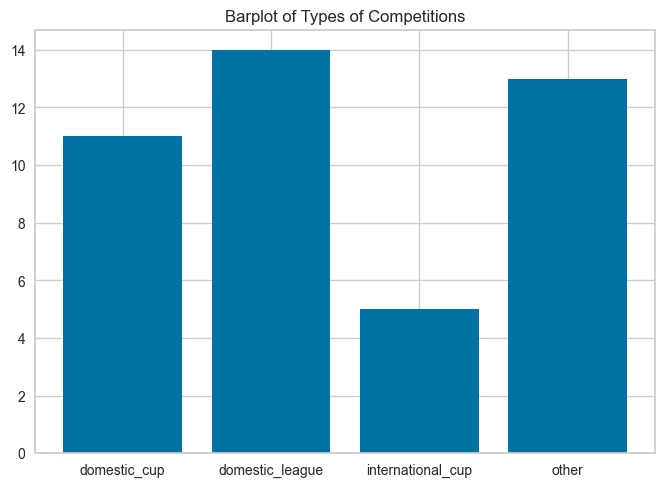

In [91]:
plt.bar(df_comp_type['type'], df_comp_type["competition_id"])
plt.title("Barplot of Types of Competitions")

In [92]:
df_comp_cont = df_comp.groupby(by="country_name").count().reset_index()

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13],
 [Text(0, 0, 'Belgium'),
  Text(1, 0, 'Denmark'),
  Text(2, 0, 'England'),
  Text(3, 0, 'France'),
  Text(4, 0, 'Germany'),
  Text(5, 0, 'Greece'),
  Text(6, 0, 'Italy'),
  Text(7, 0, 'Netherlands'),
  Text(8, 0, 'Portugal'),
  Text(9, 0, 'Russia'),
  Text(10, 0, 'Scotland'),
  Text(11, 0, 'Spain'),
  Text(12, 0, 'Turkey'),
  Text(13, 0, 'Ukraine')])

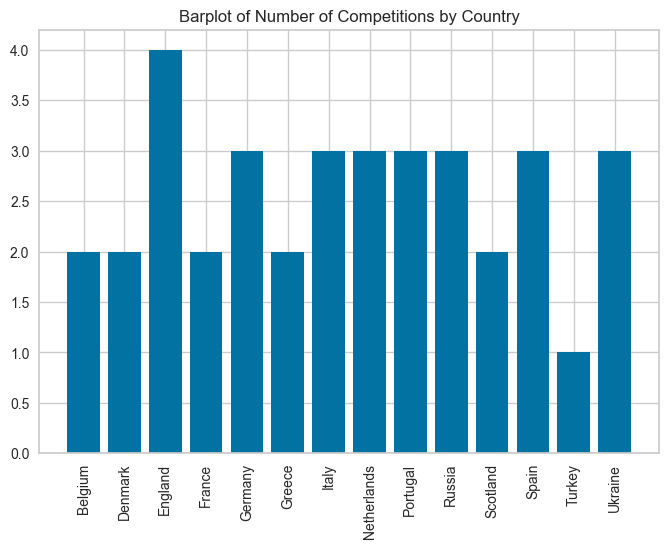

In [93]:
bar_plot = plt.bar(df_comp_cont['country_name'], df_comp_cont["competition_id"])
plt.title("Barplot of Number of Competitions by Country")
plt.xticks(rotation=90)

In [94]:
df_comp_subtype = df_comp.groupby(by="sub_type").count().reset_index()

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
 [Text(0, 0, 'domestic_cup'),
  Text(1, 0, 'domestic_super_cup'),
  Text(2, 0, 'europa_league'),
  Text(3, 0, 'europa_league_qualifying'),
  Text(4, 0, 'fifa_club_world_cup'),
  Text(5, 0, 'first_tier'),
  Text(6, 0, 'league_cup'),
  Text(7, 0, 'uefa_champions_league'),
  Text(8, 0, 'uefa_champions_league_qualifying'),
  Text(9, 0, 'uefa_europa_conference_league_qualifiers'),
  Text(10, 0, 'uefa_super_cup')])

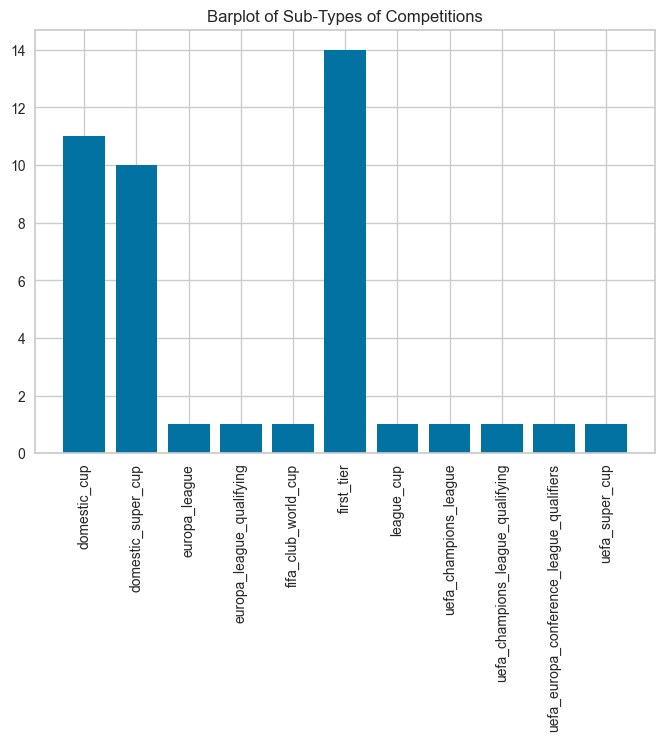

In [95]:
plt.bar(df_comp_subtype['sub_type'], df_comp_subtype["competition_id"])
plt.title("Barplot of Sub-Types of Competitions")
plt.xticks(rotation=90)